# Setup

In [ ]:
%pip install torch-geometric

In [1]:
import os
import math
import time
import psutil
import random
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
random_seed = 42

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(random_seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

using cpu


# Data Pre-Processing

In [3]:
dataset_path = '/Users/gitaayusalsabila/Documents/0thesis/code/sandbox/dataset/'
# dataset_path = '/notebooks/dataset/'

### Features Preprocessing

#### Laplacian Feature

In [48]:
from scipy.sparse.linalg import eigsh, ArpackError
from scipy.sparse import csgraph
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def laplacian_positional_encoding(adj_matrix, dim, ncv=None):
    laplacian = csgraph.laplacian(adj_matrix, normed=True)
    try:
        eigvals, eigvecs = eigsh(laplacian, k=dim + 1, which='SM', ncv=ncv)
        encoding = torch.tensor(eigvecs[:, 1:], dtype=torch.float)  # Skip the first eigenvector
    except ArpackError as e:
        print(f"ARPACK error for matrix with shape {adj_matrix.shape}: {e}")
        encoding = torch.zeros((adj_matrix.shape[0], dim), dtype=torch.float)  # Fallback to zero encoding
    return encoding

def process_graph_multiple_domain(args):
    i, t, d, graphs, num_nodes, feature_dim = args
    adj_matrix = graphs[i, t, :, :, d]
    return (i, t, d, laplacian_positional_encoding(adj_matrix, feature_dim).numpy())

def process_graph_single_domain(args):
    i, t, graphs, num_nodes, feature_dim = args
    adj_matrix = graphs[i, t, :, :]
    return (i, t, laplacian_positional_encoding(adj_matrix, feature_dim).numpy())

def laplacian_initialization(graphs, num_domains=1, feature_dim=8):
    if num_domains > 1:
        num_graphs, num_timepoints, num_nodes, _, num_domains = graphs.shape
        node_features = np.zeros((num_graphs, num_timepoints, num_nodes, feature_dim, num_domains))
        tasks = [(i, t, d, graphs, num_nodes, feature_dim) for i in range(num_graphs) for t in range(num_timepoints) for d in range(num_domains)]
        with ThreadPoolExecutor() as executor:
            for i, t, d, encoding in tqdm(executor.map(process_graph_multiple_domain, tasks), total=len(tasks)):
                node_features[i, t, :, :, d] = encoding
    else:
        num_graphs, num_timepoints, num_nodes, _ = graphs.shape
        node_features = np.zeros((num_graphs, num_timepoints, num_nodes, feature_dim))
        tasks = [(i, t, graphs, num_nodes, feature_dim) for i in range(num_graphs) for t in range(num_timepoints)]
        with ThreadPoolExecutor() as executor:
            for i, t, encoding in tqdm(executor.map(process_graph_single_domain, tasks), total=len(tasks)):
                node_features[i, t, :, :] = encoding

    return node_features

## slim160
slim160_laplacian_features = laplacian_initialization(slim160_cleaned)
print(slim160_laplacian_features.shape)

np.save(dataset_path + 'slim160_laplacian_features_8.npy', slim160_laplacian_features)

100%|██████████| 327/327 [00:02<00:00, 114.19it/s]

ARPACK error for matrix with shape (160, 160): ARPACK error 3: No shifts could be applied during a cycle of the Implicitly restarted Arnoldi iteration. One possibility is to increase the size of NCV relative to NEV. 
(109, 3, 160, 8)


#### Cognitive Feature

In [4]:
# Load the CSV data
csv_file = 'slim160_r2_subgraphs.csv'
df = pd.read_csv(dataset_path + csv_file)

# Initialize numpy arrays
num_subjects = 109
num_timepoints = 3
num_nodes = 160
num_features = 3

slim160_cognitive_features = np.zeros((num_subjects, num_timepoints, num_nodes, num_features))
slim160_number_cognitive_features = np.zeros((num_subjects, num_timepoints, num_nodes, 1))
slim160_image_cognitive_features = np.zeros((num_subjects, num_timepoints, num_nodes, 1))
slim160_word_cognitive_features = np.zeros((num_subjects, num_timepoints, num_nodes, 1))

# Populate the numpy arrays
for index, row in df.iterrows():
    subject = int(row['Subject'])
    timepoint = int(row['Timepoint'])
    subgraph_index = int(row['Subgraph_Index'])
    
    number_r2 = row['Number_R2']
    image_r2 = row['Image_R2']
    word_r2 = row['Word_R2']
    
    slim160_cognitive_features[subject, timepoint, subgraph_index] = [number_r2, image_r2, word_r2]
    slim160_number_cognitive_features[subject, timepoint, subgraph_index] = [number_r2]
    slim160_image_cognitive_features[subject, timepoint, subgraph_index] = [image_r2]
    slim160_word_cognitive_features[subject, timepoint, subgraph_index] = [word_r2]

# Print shapes of the resulting arrays to verify
print("Shape of slim160_cognitive_features:", slim160_cognitive_features.shape)
print("Shape of slim160_number_cognitive_features:", slim160_number_cognitive_features.shape)
print("Shape of slim160_image_cognitive_features:", slim160_image_cognitive_features.shape)
print("Shape of slim160_word_cognitive_features:", slim160_word_cognitive_features.shape)

np.save(dataset_path + 'slim160_cognitive_features.npy',slim160_cognitive_features)
np.save(dataset_path + 'slim160_cognitive_number_features.npy',slim160_number_cognitive_features)
np.save(dataset_path + 'slim160_cognitive_image_features.npy',slim160_image_cognitive_features)
np.save(dataset_path + 'slim160_cognitive_word_features.npy',slim160_word_cognitive_features)

Shape of slim160_cognitive_features: (109, 3, 160, 3)
Shape of slim160_number_cognitive_features: (109, 3, 160, 1)
Shape of slim160_image_cognitive_features: (109, 3, 160, 1)
Shape of slim160_word_cognitive_features: (109, 3, 160, 1)


### Data loading

In [5]:
def compute_path_lengths(data):
    longest_path = 0
    shortest_path = float('inf')
    average_paths = []

    # Check if the data is a single graph or a dataset of graphs
    if isinstance(data, list) or isinstance(data, DataLoader):
        graphs = data
    else:
        graphs = [data]

    for graph in graphs:
        G = to_networkx(graph, to_undirected=True)
        
        # Compute shortest path lengths
        path_lengths = dict(nx.all_pairs_shortest_path_length(G))
        graph_longest_path = 0
        graph_total_path_length = 0
        graph_total_paths = 0
        
        for lengths in path_lengths.values():
            for length in lengths.values():
                if length > graph_longest_path:
                    graph_longest_path = length
                if length < shortest_path:
                    shortest_path = length
                graph_total_path_length += length
                graph_total_paths += 1

        # Update the overall longest path
        if graph_longest_path > longest_path:
            longest_path = graph_longest_path

        # Calculate the average path length for this graph
        if graph_total_paths > 0:
            graph_average_path = graph_total_path_length / graph_total_paths
            average_paths.append(graph_average_path)
    
    overall_average_path = np.mean(average_paths) if average_paths else 0
    std_average_path = np.std(average_paths) if average_paths else 0
    shortest_path = shortest_path if shortest_path != float('inf') else 0
    
    return int(longest_path), int(shortest_path), overall_average_path, std_average_path

def multivariate_simulate(datapath, n_samples=200,n_time=2,n_views=4):
    # Note that changing the node count is not provided right now, since we use correlation matrix
    # and the mean values of connectivities from real data and it is for 35 nodes.
    
    # Import all required statistical information.
    allstats = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # Connectivity mean values of LH. You can also try with RH.
    allcorrs = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # Correlation matrix in LH. You can also try with RH.
    all_diffs = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # This is an overall representation of time differences in both (LH and RH) datasets.
    
    times = []
    for t in range(n_time):
        views = []
        for v in range(n_views):
            # Note that we randomly assign a new random state to ensure it will generate a different dataset at each run.
            # Generate data with the correlations and mean values at the current timepoint.
            if t < 2:
                connectomic_means = allstats[t,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[t,v],n_samples,random_state=randint(1,9999))
            # If the requested timepoints are more than we have in real data, use the correlation information from the last timepoint.
            else:
                connectomic_means = allstats[-1,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[-1,v],n_samples,random_state=randint(1,9999))

            adj = []
            for idx, sample in enumerate(data):
                # Create adjacency matrix.
                matrix = antiVectorize(sample,35)
                # Perturb the real time difference with nonlinear tanh function.
                noise = np.tanh( t / n_time )
                # Further timepoints will have more significant difference from the baseline (t=6 >> t=1).
                matrix = matrix + all_diffs[:,:,v] * ( noise + 1 )
                adj.append(matrix)
            views.append(np.array(adj))

        times.append(np.array(views))
    
    alldata=np.array(times)
    alldata = np.transpose(alldata,(2,0,3,4,1))
    return alldata 

def prepare_data(datapath, new_data=False, n_samples=200, n_times=6):
    # Note that data with 200 samples and 6 timepoints is very large (5.8M data points),
    # check your GPU memory to make sure there is enough space to allocate. If not, try:
    # - to reduce dataset size by changing n_samples or n_times.
    # - on CPU (this will allocate memory on RAM) --> This might work for example if you have 1GB GPU memory but 16GB RAM.
    # - on another computer with a better NVIDIA graphics card. --> 2GB GPU memory will not be enough for 5.8M data.
    try:
        if new_data:
            samples = multivariate_simulate(datapath, n_samples, n_times)
            np.save(datapath + 'simulated_adj.npy',samples)
        else:
            samples = np.load(datapath + 'simulated_adj.npy')
    except:
        samples = multivariate_simulate(datapath, n_samples, n_times)
        np.save(datapath + 'simulated_adj.npy',samples)
    return samples

def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

def check_and_drop_invalid_graphs(graph_dataset):
    """
    Check that all graphs in the dataset have more than 0 edges and drop graphs with 0 edges in any timepoint or dimension.
    
    Parameters:
    graph_dataset (np.ndarray): The input graph dataset with shape [g, t, n, n, d] or [g, t, n, n]
    
    Returns:
    np.ndarray: The cleaned dataset with invalid graphs removed
    """
    
    # Check the shape of the dataset to determine if it has multiple dimensions
    if len(graph_dataset.shape) == 5:
        num_graphs, num_timepoints, num_nodes, _, num_dimensions = graph_dataset.shape
    else:
        num_graphs, num_timepoints, num_nodes, _ = graph_dataset.shape
        num_dimensions = 1
    
    valid_graphs = []

    for i in range(num_graphs):
        is_valid = True
        for t in range(num_timepoints):
            for d in range(num_dimensions):
                if num_dimensions > 1:
                    adj_matrix = graph_dataset[i, t, :, :, d]
                else:
                    adj_matrix = graph_dataset[i, t, :, :]
                
                num_edges = np.sum(adj_matrix > 0)
                if num_edges == 0:
                    is_valid = False
                    break
            if not is_valid:
                break
        
        if is_valid:
            valid_graphs.append(i)
    
    if num_dimensions > 1:
        cleaned_dataset = graph_dataset[valid_graphs, :, :, :, :]
    else:
        cleaned_dataset = graph_dataset[valid_graphs, :, :, :]
    
    return cleaned_dataset


In [6]:
# Load Graph Data
simulated_data = prepare_data(dataset_path, new_data=False, n_samples=100, n_times=3)
slim160 = np.load(dataset_path + 'slim160_adj.npy')
slim268 = np.load(dataset_path + 'slim268_adj.npy')


# Clean Computed Graph Adj Matrix
simulated_cleaned = data_cleansing(simulated_data)
simulated_cleaned = check_and_drop_invalid_graphs(simulated_data)
print('simulated data shape:',simulated_cleaned.shape)

slim160_cleaned = data_cleansing(slim160)
slim160_cleaned = check_and_drop_invalid_graphs(slim160_cleaned)
print('slim160 shape:',slim160_cleaned.shape)

slim268_cleaned = data_cleansing(slim268)
slim268_cleaned = check_and_drop_invalid_graphs(slim268_cleaned)
print('slim268 shape:',slim268_cleaned.shape)


# Load Precomputed Graph (Node) Features
## Laplacian Encoding
simulated_laplacian_features = np.load(dataset_path + 'simulated_laplacian_features.npy')
print("Shape of simulated_laplacian_features:", simulated_laplacian_features.shape) 
slim160_laplacian_features = np.load(dataset_path + 'slim160_laplacian_features_8.npy') 
print("Shape of slim160_laplacian_features:", slim160_laplacian_features.shape)
slim268_laplacian_features = np.load(dataset_path + 'slim268_laplacian_features.npy') 
print("Shape of slim268_laplacian_features:", slim268_laplacian_features.shape)


## Degree Features
simulated_degree_features = np.load(dataset_path + 'simulated_degree_features.npy') 
print("Shape of slim160_ones_features:", simulated_degree_features.shape)
slim160_degree_features = np.load(dataset_path + 'slim160_degree_features.npy')
print("Shape of slim160_ones_features:", slim160_degree_features.shape) 
slim268_degree_features = np.load(dataset_path + 'slim268_degree_features.npy') 
print("Shape of slim160_ones_features:", slim268_degree_features.shape)

## Cognitive Features
slim160_cognitive_features = np.load(dataset_path + 'slim160_cognitive_features.npy') 
print("Shape of slim160_cognitive_features:", slim160_cognitive_features.shape)
slim160_cognitive_number_features = np.load(dataset_path + 'slim160_cognitive_number_features.npy') 
print("Shape of slim160_number_features:", slim160_cognitive_number_features.shape)
slim160_cognitive_image_features = np.load(dataset_path + 'slim160_cognitive_image_features.npy') 
print("Shape of slim160_image_features:", slim160_cognitive_image_features.shape)
slim160_cognitive_word_features = np.load(dataset_path + 'slim160_cognitive_word_features.npy') 
print("Shape of slim160_word_features:", slim160_cognitive_word_features.shape)

## Ones Features
slim160_ones_features = np.ones((109, 3, 160, 3))
print("Shape of slim160_ones_features:", slim160_ones_features.shape)

## Random Features
slim160_random_features = np.random.rand(109, 3, 160, 3) * 10
print("Shape of slim160_random_features:", slim160_random_features.shape)

simulated data shape: (100, 3, 35, 35, 4)


slim160 shape: (109, 3, 160, 160)
slim268 shape: (109, 3, 268, 268)
Shape of simulated_laplacian_features: (100, 3, 35, 8, 4)
Shape of slim160_laplacian_features: (109, 3, 160, 8)
Shape of slim268_laplacian_features: (109, 3, 268, 32)
Shape of slim160_ones_features: (100, 3, 35, 1, 4)
Shape of slim160_ones_features: (109, 3, 160, 1)
Shape of slim160_ones_features: (109, 3, 268, 1)
Shape of slim160_cognitive_features: (109, 3, 160, 3)
Shape of slim160_number_features: (109, 3, 160, 1)
Shape of slim160_image_features: (109, 3, 160, 1)
Shape of slim160_word_features: (109, 3, 160, 1)
Shape of slim160_ones_features: (109, 3, 160, 3)
Shape of slim160_random_features: (109, 3, 160, 3)


#### Data Processing

In [7]:
def convert_to_pyg_data(adj_matrices, inp_features):
    pyg_data_list = []
    
    num_graphs = adj_matrices.shape[0]
    num_timepoints = adj_matrices.shape[1]
    
    for i in range(num_graphs):
        for t in range(num_timepoints):
            adj_matrix = adj_matrices[i, t]
            features = inp_features[i, t]
            
            # Get edge indices
            edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
            
            # Get edge attributes
            edge_attr = torch.tensor(adj_matrix[adj_matrix.nonzero()], dtype=torch.float)
            
            # Node features
            x = torch.tensor(features, dtype=torch.float)
            
            # Label (timepoint)
            y = torch.tensor([t], dtype=torch.long)
            
            pyg_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            pyg_data_list.append(pyg_data)
    
    return pyg_data_list

In [8]:
pyg_data_list_laplacian = convert_to_pyg_data(slim160_cleaned, slim160_laplacian_features)
print(pyg_data_list_laplacian[0])

pyg_data_list_degree = convert_to_pyg_data(slim160_cleaned, slim160_degree_features)
print(pyg_data_list_degree[0])

pyg_data_list_cognitive = convert_to_pyg_data(slim160_cleaned, slim160_cognitive_features)
print(pyg_data_list_cognitive[0])

pyg_data_list_cognitive_number = convert_to_pyg_data(slim160_cleaned, slim160_cognitive_number_features)
print(pyg_data_list_cognitive_number[0])

pyg_data_list_cognitive_image = convert_to_pyg_data(slim160_cleaned, slim160_cognitive_image_features)
print(pyg_data_list_cognitive_image[0])

pyg_data_list_cognitive_word = convert_to_pyg_data(slim160_cleaned, slim160_cognitive_word_features)
print(pyg_data_list_cognitive_word[0])

pyg_data_list_ones = convert_to_pyg_data(slim160_cleaned, slim160_ones_features)
print(pyg_data_list_ones[0])

pyg_data_list_random = convert_to_pyg_data(slim160_cleaned, slim160_random_features)
print(pyg_data_list_random[0])

Data(x=[160, 8], edge_index=[2, 19994], edge_attr=[19994], y=[1])
Data(x=[160, 1], edge_index=[2, 19994], edge_attr=[19994], y=[1])
Data(x=[160, 3], edge_index=[2, 19994], edge_attr=[19994], y=[1])
Data(x=[160, 1], edge_index=[2, 19994], edge_attr=[19994], y=[1])
Data(x=[160, 1], edge_index=[2, 19994], edge_attr=[19994], y=[1])
Data(x=[160, 1], edge_index=[2, 19994], edge_attr=[19994], y=[1])
Data(x=[160, 3], edge_index=[2, 19994], edge_attr=[19994], y=[1])
Data(x=[160, 3], edge_index=[2, 19994], edge_attr=[19994], y=[1])


In [9]:
batch_size = 32

set_seed(42)
train_val_data_ones, test_data_ones = train_test_split(pyg_data_list_ones, test_size=0.2, random_state=42)
train_data_ones, val_data_ones = train_test_split(train_val_data_ones, test_size=0.1, random_state=42)
train_loader_ones = DataLoader(train_data_ones, batch_size=batch_size, shuffle=True)
val_loader_ones = DataLoader(val_data_ones, batch_size=batch_size, shuffle=False)
test_loader_ones = DataLoader(test_data_ones, batch_size=batch_size, shuffle=False)

set_seed(42)
train_val_data_degree, test_data_degree = train_test_split(pyg_data_list_degree, test_size=0.2, random_state=42)
train_data_degree, val_data_degree = train_test_split(train_val_data_degree, test_size=0.1, random_state=42)
train_loader_degree = DataLoader(train_data_degree, batch_size=batch_size, shuffle=True)
val_loader_degree = DataLoader(val_data_degree, batch_size=batch_size, shuffle=False)
test_loader_degree = DataLoader(test_data_degree, batch_size=batch_size, shuffle=False)

set_seed(42)
train_val_data_laplacian, test_data_laplacian = train_test_split(pyg_data_list_laplacian, test_size=0.2, random_state=42)
train_data_laplacian, val_data_laplacian= train_test_split(train_val_data_laplacian, test_size=0.1, random_state=42)
train_loader_laplacian = DataLoader(train_data_laplacian, batch_size=batch_size, shuffle=True)
val_loader_laplacian = DataLoader(val_data_laplacian, batch_size=batch_size, shuffle=False)
test_loader_laplacian = DataLoader(test_data_laplacian, batch_size=batch_size, shuffle=False)

set_seed(42)
train_val_data_cognitive, test_data_cognitive = train_test_split(pyg_data_list_cognitive, test_size=0.2, random_state=42)
train_data_cognitive, val_data_cognitive = train_test_split(train_val_data_cognitive, test_size=0.1, random_state=42)
train_loader_cognitive = DataLoader(train_data_cognitive, batch_size=batch_size, shuffle=True)
val_loader_cognitive = DataLoader(val_data_cognitive, batch_size=batch_size, shuffle=False)
test_loader_cognitive = DataLoader(test_data_cognitive, batch_size=batch_size, shuffle=False)

set_seed(42)
train_val_data_number, test_data_number = train_test_split(pyg_data_list_cognitive_number, test_size=0.2, random_state=42)
train_data_number, val_data_number = train_test_split(train_val_data_number, test_size=0.1, random_state=42)
train_loader_number = DataLoader(train_data_number, batch_size=batch_size, shuffle=True)
val_loader_number = DataLoader(val_data_number, batch_size=batch_size, shuffle=False)
test_loader_number = DataLoader(test_data_number, batch_size=batch_size, shuffle=False)

set_seed(42)
train_val_data_image, test_data_image = train_test_split(pyg_data_list_cognitive_image, test_size=0.2, random_state=42)
train_data_image, val_data_image = train_test_split(train_val_data_image, test_size=0.1, random_state=42)
train_loader_image = DataLoader(train_data_image, batch_size=batch_size, shuffle=True)
val_loader_image = DataLoader(val_data_image, batch_size=batch_size, shuffle=False)
test_loader_image = DataLoader(test_data_image, batch_size=batch_size, shuffle=False)

set_seed(42)
train_val_data_word, test_data_word = train_test_split(pyg_data_list_cognitive_word, test_size=0.2, random_state=42)
train_data_word, val_data_word = train_test_split(train_val_data_word, test_size=0.1, random_state=42)
train_loader_word = DataLoader(train_data_word, batch_size=batch_size, shuffle=True)
val_loader_word = DataLoader(val_data_word, batch_size=batch_size, shuffle=False)
test_loader_word = DataLoader(test_data_word, batch_size=batch_size, shuffle=False)

set_seed(42)
train_val_data_random, test_data_random = train_test_split(pyg_data_list_random, test_size=0.2, random_state=42)
train_data_random, val_data_random = train_test_split(train_val_data_random, test_size=0.1, random_state=42)
train_loader_random = DataLoader(train_data_random, batch_size=batch_size, shuffle=True)
val_loader_random = DataLoader(val_data_random, batch_size=batch_size, shuffle=False)
test_loader_random = DataLoader(test_data_random, batch_size=batch_size, shuffle=False)

num_features_ones = slim160_ones_features.shape[-1]
num_features_random = slim160_random_features.shape[-1]
num_features_degree = slim160_degree_features.shape[-1]
num_features_laplacian = slim160_laplacian_features.shape[-1]
num_features_cognitive = slim160_cognitive_features.shape[-1]
num_features_cognitive_number = slim160_cognitive_number_features.shape[-1]
num_features_cognitive_image = slim160_cognitive_image_features.shape[-1]
num_features_cognitive_word = slim160_cognitive_word_features.shape[-1]

num_classes = slim160_cleaned.shape[1]

In [10]:
# Compute path lengths for the train loader
longest_path, shortest_path, overall_average_path, std_average_path = compute_path_lengths(train_loader_ones)
print(f'SLIM160 dataset - Longest path: {longest_path}')
print(f'SLIM160 dataset - Shortest path: {shortest_path}')
print(f'SLIM160 dataset - Overall average path: {overall_average_path:.2f}')
print(f'SLIM160 dataset - Standard deviation of average paths: {std_average_path:.2f}')

SLIM160 dataset - Longest path: 2
SLIM160 dataset - Shortest path: 0
SLIM160 dataset - Overall average path: 1.30
SLIM160 dataset - Standard deviation of average paths: 0.02


# Model Definition

### Models

In [11]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.fc = torch.nn.Linear(hidden_features*2, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = F.relu(self.gcn2(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN3Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN3Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.gcn3 = GCN(hidden_features*2, hidden_features)
        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = F.relu(self.gcn2(x, adj))
        x = F.relu(self.gcn3(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


##GCESN
class GCESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=5):
        super(GCESN_var1, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(adj, torch.mm(h, self.W)))
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=6):
        super(GCESN_var2, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(x, self.W) + torch.mm(adj, torch.mm(h, self.W)))
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


###GCNESN
class GCNESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var1, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        n_node, _ = x.shape 
        
        # # initialize state with zero
        state = torch.zeros(n_node, self.hidden_features).to(device)
        # state = x
        # print(f'state shape: {state.shape}, x shape: {x.shape}, Win shape: {self.Win.shape}, W shape: {self.W.shape}')
        
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))

        x = global_mean_pool(state, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCNESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var2, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        n_node, _ = x.shape 
        
        # # initialize state with zero
        state = torch.zeros(n_node, self.hidden_features).to(device)
        
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        x = F.relu(self.gcn2(state, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### Functions


In [12]:
def train_graph(model, loader, val_loader, lr=0.001, num_epochs=100, patience=5, step_size=50, gamma=0.1,save_path='models/gcn_x.pth'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.to(device)

    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)

            optimizer.zero_grad()
            output = model(x, adj_matrix, batch)
            loss = criterion(output, data.y.to(device))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.num_graphs
        
        scheduler.step()  # Step the learning rate scheduler

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB
        training_loss.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                x, edge_index, batch = val_data.x.to(device), val_data.edge_index.to(device), val_data.batch.to(device)
                adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
                val_output = model(x, adj_matrix, batch)
                val_loss += criterion(val_output, val_data.y.to(device)).item() * val_data.num_graphs

        validation_loss.append(val_loss)

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            total_epoch = epoch+1
            torch.save(model.state_dict(), save_path)  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                total_epoch = epoch+1
                break

        print(f'Epoch {epoch + 1}, Train Loss: {epoch_loss}, Val Loss: {val_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB')

    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load(save_path))
    print(f'Model saved to {save_path}')

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage = np.mean(cpu_usage)
    avg_memory_usage = np.mean(memory_usage)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage = np.max(cpu_usage)
    max_memory_usage = np.max(memory_usage)

    print(f'Average Time per Epoch: {avg_epoch_time:.2f}s')
    print(f'Average CPU Usage: {avg_cpu_usage:.2f}GB')
    print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')

    print(f'\nTotal Training Time: {total_training_time:.2f}s')
    print(f'Max CPU Usage: {max_cpu_usage:.2f}GB')
    print(f'Max Memory Usage: {max_memory_usage:.2f}GB')

    return


def evaluate(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix:\n{cm}')

    # Calculate metrics
    accuracy = np.trace(cm) / np.sum(cm)
    sensitivity = np.zeros(cm.shape[0])
    specificity = np.zeros(cm.shape[0])
    
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)

        sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0

    avg_sensitivity = np.mean(sensitivity)
    avg_specificity = np.mean(specificity)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Average Sensitivity (Recall): {avg_sensitivity:.4f}')
    print(f'Average Specificity: {avg_specificity:.4f}')

    return accuracy, avg_sensitivity, avg_specificity


def test_graph(model, loader):
    model.to(device)
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    accuracy, sensitivity, specificity = evaluate(y_true, y_pred)
    return


In [13]:
def train_graph_multiple(model, loader, val_loader, lr=0.001, num_epochs=100, patience=5, step_size=50, gamma=0.1, save_path='models/gcn_x.pth'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.to(device)

    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)

            optimizer.zero_grad()
            output = model(x, adj_matrix, batch)
            loss = criterion(output, data.y.to(device))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.num_graphs

        scheduler.step()  # Step the learning rate scheduler
        
        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB
        training_loss.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                x, edge_index, batch = val_data.x.to(device), val_data.edge_index.to(device), val_data.batch.to(device)
                adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
                val_output = model(x, adj_matrix, batch)
                val_loss += criterion(val_output, val_data.y.to(device)).item() * val_data.num_graphs

        validation_loss.append(val_loss)

        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            total_epoch = epoch+1
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                total_epoch = epoch+1
                break

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage = np.mean(cpu_usage)
    avg_memory_usage = np.mean(memory_usage)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage = np.max(cpu_usage)
    max_memory_usage = np.max(memory_usage)

    return training_loss[-1], total_training_time, avg_cpu_usage, avg_memory_usage, max_cpu_usage, max_memory_usage, total_epoch  

def evaluate_multiple(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    cm = confusion_matrix(y_true, y_pred)

    accuracy = np.trace(cm) / np.sum(cm)
    sensitivity = np.zeros(cm.shape[0])
    specificity = np.zeros(cm.shape[0])
    
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)

        sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0

    avg_sensitivity = np.mean(sensitivity)
    avg_specificity = np.mean(specificity)

    return accuracy, avg_sensitivity, avg_specificity

def test_graph_multiple(model, loader):
    model.to(device)
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    accuracy, sensitivity, specificity = evaluate_multiple(y_true, y_pred)
    return accuracy, sensitivity, specificity
    
def train_and_evaluate_multiple_runs_graph(model, train_loader, val_loader, test_loader, num_runs=50, num_epochs=500, path='models/multiple_run/gcesn_v1_graph_'):
    all_accuracies = []
    all_sensitivities = []
    all_specificities = []
    all_training_times = []
    all_avg_cpu_usages = []
    all_avg_memory_usages = []
    all_max_cpu_usages = []
    all_max_memory_usages = []
    all_epoch = []

    for run in range(num_runs):
        # Train the model
        save_path = path + f'_run{run}.pth'
        loss, training_time, avg_cpu, avg_memory, max_cpu, max_memory, total_epoch = train_graph_multiple(model, train_loader, val_loader, lr=0.01, num_epochs=num_epochs, save_path=save_path)
        
        # Test the model
        accuracy, sensitivity, specificity = test_graph_multiple(model, test_loader)

        # Store results
        all_accuracies.append(accuracy)
        all_sensitivities.append(sensitivity)
        all_specificities.append(specificity)
        all_training_times.append(training_time)
        all_avg_cpu_usages.append(avg_cpu)
        all_avg_memory_usages.append(avg_memory)
        all_max_cpu_usages.append(max_cpu)
        all_max_memory_usages.append(max_memory)
        all_epoch.append(total_epoch)

        print(f'\nRun {run+1}/{num_runs} -> Loss: {loss}')
        print(f'  Total Training Time: {training_time:.2f}s, Avg CPU Usage: {avg_cpu:.2f}GB, Avg Memory Usage: {avg_memory:.2f}GB, Max CPU Usage: {max_cpu:.2f}GB, Max Memory Usage: {max_memory:.2f}GB')
        print(f'  Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')

    # Compute average values across all runs
    avg_accuracy = np.mean(all_accuracies)
    avg_sensitivity = np.mean(all_sensitivities)
    avg_specificity = np.mean(all_specificities)
    avg_training_time = np.mean(all_training_times)
    avg_cpu_usage = np.mean(all_avg_cpu_usages)
    avg_memory_usage = np.mean(all_avg_memory_usages)
    avg_max_cpu_usage = np.mean(all_max_cpu_usages)
    avg_max_memory_usage = np.mean(all_max_memory_usages)
    avg_num_epoch = np.mean(all_epoch)

    print('Overall Results:')
    print(f'  Avg Accuracy: {avg_accuracy:.4f}, Avg Sensitivity: {avg_sensitivity:.4f}, Avg Specificity: {avg_specificity:.4f}')
    print(f'  Avg Num Epoch:{avg_num_epoch:.2f}, Avg Training Time: {avg_training_time:.2f}s') 
    print(f'  Avg CPU Usage: {avg_cpu_usage:.2f}GB, Avg Memory Usage: {avg_memory_usage:.2f}GB, Avg Max CPU Usage: {avg_max_cpu_usage:.2f}GB, Avg Max Memory Usage: {avg_max_memory_usage:.2f}GB')

# SLIM160 Training

## GCN

#### GCN 1-Layer

##### Ones Features

GCN1Layer(
  (gcn1): GCN (3 -> 128)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Total number of trainable parameters: 899

Epoch 1, Train Loss: 884.680557012558, Val Loss: 43.90198838710785
Time: 0.80s, CPU: 2.27GB, Memory: 2.73GB
Epoch 2, Train Loss: 431.63835310935974, Val Loss: 51.295873045921326
Time: 0.34s, CPU: 3.44GB, Memory: 2.72GB
Epoch 3, Train Loss: 310.94833850860596, Val Loss: 31.52898609638214
Time: 0.33s, CPU: 2.88GB, Memory: 2.66GB
Epoch 4, Train Loss: 294.84850573539734, Val Loss: 29.989283323287964
Time: 0.34s, CPU: 2.82GB, Memory: 2.67GB
Epoch 5, Train Loss: 264.61752557754517, Val Loss: 33.23452663421631
Time: 0.33s, CPU: 2.71GB, Memory: 2.67GB
Epoch 6, Train Loss: 264.58139753341675, Val Loss: 29.48039209842682
Time: 0.36s, CPU: 3.54GB, Memory: 2.67GB
Epoch 7, Train Loss: 260.7723250389099, Val Loss: 29.97394323348999
Time: 0.34s, CPU: 3.02GB, Memory: 2.75GB
Epoch 8, Train Loss: 258.2045783996582, Val Loss: 30.369705319404602
Time: 0.35s, CPU: 3.10

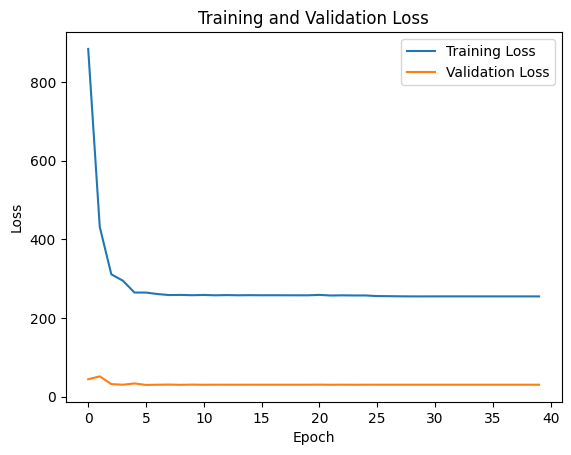

Model saved to models/gcn_1l_graph_ones.pth
Average Time per Epoch: 0.36s
Average CPU Usage: 2.93GB
Average Memory Usage: 2.74GB

Total Training Time: 14.45s
Max CPU Usage: 5.78GB
Max Memory Usage: 2.82GB


In [13]:
set_seed(42)
gcn1_graph_ones = GCN1Layer(num_features_ones, 128, num_classes)
print(gcn1_graph_ones)
print(f"Total number of trainable parameters: {(gcn1_graph_ones.count_parameters())}\n")

train_graph(gcn1_graph_ones, train_loader_ones, val_loader_ones, lr=0.001, 
            num_epochs=150, patience=10, step_size=25, save_path='models/gcn_1l_graph_ones.pth')

In [14]:
test_graph(gcn1_graph_ones, test_loader_ones)

Confusion Matrix:
[[ 0  0 24]
 [ 0  1 23]
 [ 0  1 17]]
Accuracy: 0.2727
Average Sensitivity (Recall): 0.3287
Average Specificity: 0.6657


##### Random Features

GCN1Layer(
  (gcn1): GCN (3 -> 128)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Total number of trainable parameters: 899

Epoch 1, Train Loss: 4166.536852836609, Val Loss: 140.8413233757019
Time: 0.40s, CPU: 3.75GB, Memory: 2.88GB
Epoch 2, Train Loss: 1503.675308227539, Val Loss: 160.86679029464722
Time: 0.35s, CPU: 3.20GB, Memory: 2.87GB
Epoch 3, Train Loss: 734.8986673355103, Val Loss: 60.748390674591064
Time: 0.35s, CPU: 3.03GB, Memory: 2.86GB
Epoch 4, Train Loss: 557.6764616966248, Val Loss: 45.385451674461365
Time: 0.35s, CPU: 3.11GB, Memory: 2.85GB
Epoch 5, Train Loss: 432.1983036994934, Val Loss: 35.387993931770325
Time: 0.35s, CPU: 3.39GB, Memory: 2.80GB
Epoch 6, Train Loss: 318.62209463119507, Val Loss: 41.132078647613525
Time: 0.33s, CPU: 2.69GB, Memory: 2.80GB
Epoch 7, Train Loss: 311.0958921909332, Val Loss: 32.216010332107544
Time: 0.33s, CPU: 2.60GB, Memory: 2.77GB
Epoch 8, Train Loss: 292.92582845687866, Val Loss: 31.010770440101624
Time: 0.60s, CPU: 6.

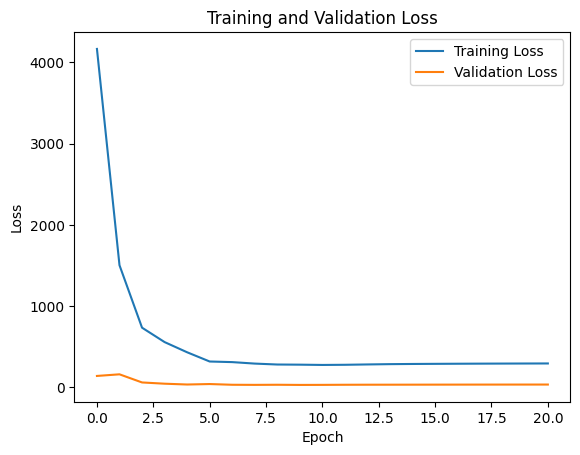

Model saved to models/gcn_1l_graph_random.pth
Average Time per Epoch: 0.36s
Average CPU Usage: 3.05GB
Average Memory Usage: 2.81GB

Total Training Time: 7.60s
Max CPU Usage: 6.27GB
Max Memory Usage: 2.88GB


In [15]:
set_seed(42)
gcn1_graph_random = GCN1Layer(num_features_random, 128, num_classes)
print(gcn1_graph_random)
print(f"Total number of trainable parameters: {(gcn1_graph_random.count_parameters())}\n")

train_graph(gcn1_graph_random, train_loader_random, val_loader_random, lr=0.001, 
            num_epochs=150, patience=10, step_size=25, save_path='models/gcn_1l_graph_random.pth')

In [16]:
test_graph(gcn1_graph_random, test_loader_random)

Confusion Matrix:
[[ 0 14 10]
 [ 0 13 11]
 [ 0 11  7]]
Accuracy: 0.3030
Average Sensitivity (Recall): 0.3102
Average Specificity: 0.6558


##### Degree Features

GCN1Layer(
  (gcn1): GCN (1 -> 128)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Total number of trainable parameters: 643

Epoch 1, Train Loss: 26893.000366210938, Val Loss: 1355.943946838379
Time: 0.39s, CPU: 3.94GB, Memory: 2.83GB
Epoch 2, Train Loss: 11492.413986206055, Val Loss: 862.9670963287354
Time: 0.34s, CPU: 2.92GB, Memory: 2.85GB
Epoch 3, Train Loss: 4779.595579147339, Val Loss: 613.6076602935791
Time: 0.33s, CPU: 2.62GB, Memory: 2.82GB
Epoch 4, Train Loss: 3259.172914505005, Val Loss: 147.74337244033813
Time: 0.36s, CPU: 3.46GB, Memory: 2.84GB
Epoch 5, Train Loss: 1475.5294437408447, Val Loss: 123.29159116744995
Time: 0.60s, CPU: 5.30GB, Memory: 2.80GB
Epoch 6, Train Loss: 1195.9902257919312, Val Loss: 41.65930652618408
Time: 0.38s, CPU: 3.33GB, Memory: 2.79GB
Epoch 7, Train Loss: 1374.1366081237793, Val Loss: 63.678231954574585
Time: 0.36s, CPU: 3.23GB, Memory: 2.73GB
Epoch 8, Train Loss: 554.1806616783142, Val Loss: 43.560476660728455
Time: 0.34s, CPU: 3.

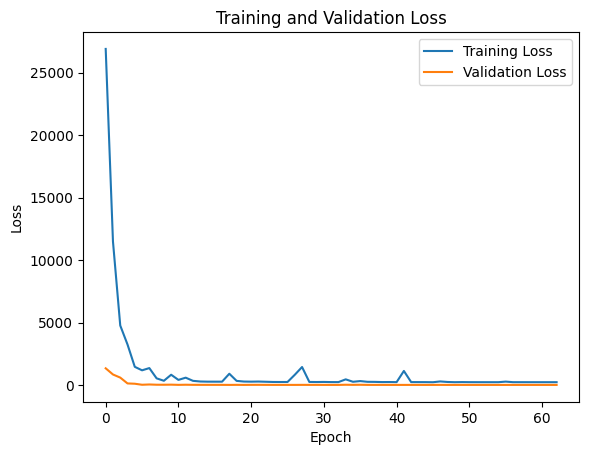

Model saved to models/gcn_1l_graph_degree.pth
Average Time per Epoch: 0.46s
Average CPU Usage: 3.28GB
Average Memory Usage: 2.75GB

Total Training Time: 28.99s
Max CPU Usage: 5.30GB
Max Memory Usage: 2.85GB


In [17]:
set_seed(42)
gcn1_graph_degree = GCN1Layer(num_features_degree, 128, num_classes)
print(gcn1_graph_degree)
print(f"Total number of trainable parameters: {(gcn1_graph_degree.count_parameters())}\n")
train_graph(gcn1_graph_degree, train_loader_degree, val_loader_degree, lr=0.01, 
            num_epochs=150, patience=10, save_path='models/gcn_1l_graph_degree.pth')

In [18]:
test_graph(gcn1_graph_degree, test_loader_degree)

Confusion Matrix:
[[15  0  9]
 [ 4  1 19]
 [ 8  1  9]]
Accuracy: 0.3788
Average Sensitivity (Recall): 0.3889
Average Specificity: 0.7024


##### Laplacian Features

GCN1Layer(
  (gcn1): GCN (8 -> 128)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Total number of trainable parameters: 1539

Epoch 1, Train Loss: 259.17736291885376, Val Loss: 29.527509927749634
Time: 0.45s, CPU: 4.69GB, Memory: 2.69GB
Epoch 2, Train Loss: 254.40717816352844, Val Loss: 29.5775728225708
Time: 0.33s, CPU: 2.78GB, Memory: 2.70GB
Epoch 3, Train Loss: 250.46426820755005, Val Loss: 30.08237314224243
Time: 0.33s, CPU: 2.75GB, Memory: 2.70GB
Epoch 4, Train Loss: 246.2743548154831, Val Loss: 29.937604665756226
Time: 0.39s, CPU: 3.42GB, Memory: 2.75GB
Epoch 5, Train Loss: 243.639426112175, Val Loss: 30.331055760383606
Time: 0.45s, CPU: 3.26GB, Memory: 2.72GB
Epoch 6, Train Loss: 239.76945316791534, Val Loss: 30.65438210964203
Time: 0.44s, CPU: 3.07GB, Memory: 2.72GB
Epoch 7, Train Loss: 236.80494105815887, Val Loss: 31.02424693107605
Time: 0.41s, CPU: 0.00GB, Memory: 2.70GB
Epoch 8, Train Loss: 234.1678318977356, Val Loss: 31.35031235218048
Time: 0.35s, CPU: 0.00

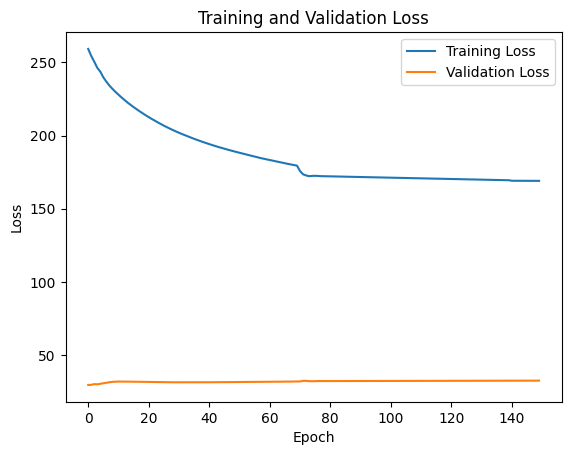

Model saved to models/gcn_1l_graph_laplacian.pth
Average Time per Epoch: 0.43s
Average CPU Usage: 2.95GB
Average Memory Usage: 2.72GB

Total Training Time: 63.80s
Max CPU Usage: 5.71GB
Max Memory Usage: 2.82GB


In [19]:
set_seed(42)
gcn1_graph_laplacian = GCN1Layer(num_features_laplacian, 128, num_classes)
print(gcn1_graph_laplacian)
print(f"Total number of trainable parameters: {gcn1_graph_laplacian.count_parameters()}\n")
train_graph(gcn1_graph_laplacian, train_loader_laplacian, val_loader_laplacian, lr=0.01, 
            num_epochs=150, patience=5, step_size=70, save_path='models/gcn_1l_graph_laplacian.pth')

In [20]:
test_graph(gcn1_graph_laplacian, test_loader_laplacian)

Confusion Matrix:
[[11  8  5]
 [ 8  4 12]
 [ 2  6 10]]
Accuracy: 0.3788
Average Sensitivity (Recall): 0.3935
Average Specificity: 0.6915


##### Cognitive Features

GCN1Layer(
  (gcn1): GCN (3 -> 128)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Total number of trainable parameters: 899

Epoch 1, Train Loss: 639.6206874847412, Val Loss: 42.48939657211304
Time: 2.03s, CPU: 2.02GB, Memory: 2.67GB
Epoch 2, Train Loss: 339.0280292034149, Val Loss: 37.97555422782898
Time: 0.71s, CPU: 4.62GB, Memory: 2.74GB
Epoch 3, Train Loss: 280.92028999328613, Val Loss: 29.58374297618866
Time: 0.33s, CPU: 3.09GB, Memory: 2.75GB
Epoch 4, Train Loss: 261.0085153579712, Val Loss: 30.077879905700684
Time: 0.34s, CPU: 3.39GB, Memory: 2.74GB
Epoch 5, Train Loss: 258.5920145511627, Val Loss: 30.70496642589569
Time: 0.36s, CPU: 2.97GB, Memory: 2.76GB
Epoch 6, Train Loss: 255.19877076148987, Val Loss: 29.932348608970642
Time: 0.36s, CPU: 2.71GB, Memory: 2.74GB
Epoch 7, Train Loss: 253.69161367416382, Val Loss: 29.931070804595947
Time: 0.36s, CPU: 2.80GB, Memory: 2.74GB
Epoch 8, Train Loss: 255.22084665298462, Val Loss: 29.974297285079956
Time: 0.36s, CPU: 3.0

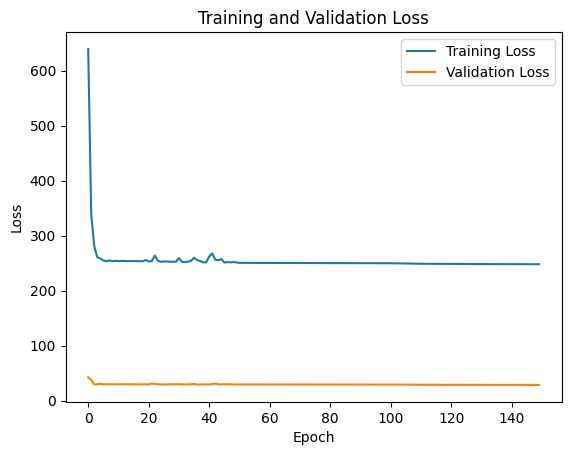

Model saved to models/gcn_1l_graph_cognitive.pth
Average Time per Epoch: 0.47s
Average CPU Usage: 3.10GB
Average Memory Usage: 2.76GB

Total Training Time: 70.03s
Max CPU Usage: 6.50GB
Max Memory Usage: 2.82GB


In [14]:
set_seed(42)
gcn1_graph_cognitive = GCN1Layer(num_features_cognitive, 128, num_classes)
print(gcn1_graph_cognitive)
print(f"Total number of trainable parameters: {(gcn1_graph_cognitive.count_parameters())}\n")
train_graph(gcn1_graph_cognitive, train_loader_cognitive, val_loader_cognitive, lr=0.01, 
            num_epochs=150, patience=10, step_size=50, save_path='models/gcn_1l_graph_cognitive.pth')

In [15]:
test_graph(gcn1_graph_cognitive, test_loader_cognitive)

Confusion Matrix:
[[ 9  2 13]
 [ 2  1 21]
 [ 6  3  9]]
Accuracy: 0.2879
Average Sensitivity (Recall): 0.3056
Average Specificity: 0.6607


#### GCN 2-Layer

##### Ones Features

GCN2Layer(
  (gcn1): GCN (3 -> 64)
  (gcn2): GCN (64 -> 128)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Total number of trainable parameters: 899

Epoch 1, Train Loss: 62308.184913635254, Val Loss: 1073.8017539978027
Time: 0.59s, CPU: 3.13GB, Memory: 2.72GB
Epoch 2, Train Loss: 4866.335570335388, Val Loss: 285.3335237503052
Time: 0.49s, CPU: 2.21GB, Memory: 2.73GB
Epoch 3, Train Loss: 1121.3562791347504, Val Loss: 31.109875917434692
Time: 1.04s, CPU: 3.89GB, Memory: 2.66GB
Epoch 4, Train Loss: 279.1898694038391, Val Loss: 29.36039113998413
Time: 0.55s, CPU: 3.24GB, Memory: 2.65GB
Epoch 5, Train Loss: 260.43387746810913, Val Loss: 29.55944538116455
Time: 0.48s, CPU: 2.20GB, Memory: 2.65GB
Epoch 6, Train Loss: 257.3045735359192, Val Loss: 29.804548859596252
Time: 0.48s, CPU: 2.03GB, Memory: 2.65GB
Epoch 7, Train Loss: 256.90504121780396, Val Loss: 29.913970112800598
Time: 0.49s, CPU: 2.44GB, Memory: 2.61GB
Epoch 8, Train Loss: 256.85016679763794, Val Loss: 29.9597843885

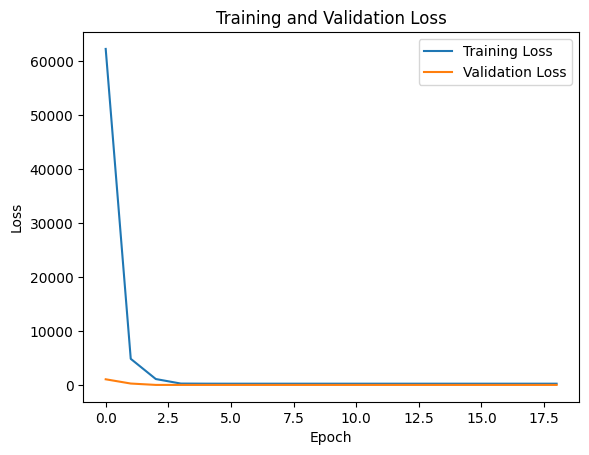

Model saved to models/gcn_2l_graph_ones.pth
Average Time per Epoch: 0.52s
Average CPU Usage: 2.21GB
Average Memory Usage: 2.66GB

Total Training Time: 9.88s
Max CPU Usage: 3.89GB
Max Memory Usage: 2.73GB


In [23]:
set_seed(42)
gcn2_graph_ones = GCN2Layer(num_features_ones, 64, num_classes)
print(gcn2_graph_ones)
print(f"Total number of trainable parameters: {(gcn1_graph_ones.count_parameters())}\n")
train_graph(gcn2_graph_ones, train_loader_ones, val_loader_ones, lr=0.01, 
            num_epochs=150, patience=10, save_path='models/gcn_2l_graph_ones.pth')

In [24]:
test_graph(gcn2_graph_ones, test_loader_ones)

Confusion Matrix:
[[ 0  0 24]
 [ 0  0 24]
 [ 0  0 18]]
Accuracy: 0.2727
Average Sensitivity (Recall): 0.3333
Average Specificity: 0.6667


##### Random Features

GCN2Layer(
  (gcn1): GCN (3 -> 64)
  (gcn2): GCN (64 -> 128)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Total number of trainable parameters: 899

Epoch 1, Train Loss: 306130.72521972656, Val Loss: 6347.871963500977
Time: 0.57s, CPU: 2.52GB, Memory: 2.75GB
Epoch 2, Train Loss: 26328.391082763672, Val Loss: 326.6443147659302
Time: 0.48s, CPU: 1.93GB, Memory: 2.77GB
Epoch 3, Train Loss: 5888.56506729126, Val Loss: 84.45656061172485
Time: 0.48s, CPU: 1.93GB, Memory: 2.77GB
Epoch 4, Train Loss: 1510.9061403274536, Val Loss: 65.54281568527222
Time: 0.48s, CPU: 2.10GB, Memory: 2.72GB
Epoch 5, Train Loss: 355.17664861679077, Val Loss: 31.54413628578186
Time: 0.48s, CPU: 2.02GB, Memory: 2.72GB
Epoch 6, Train Loss: 277.98409605026245, Val Loss: 29.410560250282288
Time: 0.48s, CPU: 1.94GB, Memory: 2.72GB
Epoch 7, Train Loss: 258.9292743206024, Val Loss: 29.803818225860596
Time: 0.48s, CPU: 2.01GB, Memory: 2.73GB
Epoch 8, Train Loss: 257.26571679115295, Val Loss: 30.042523026466

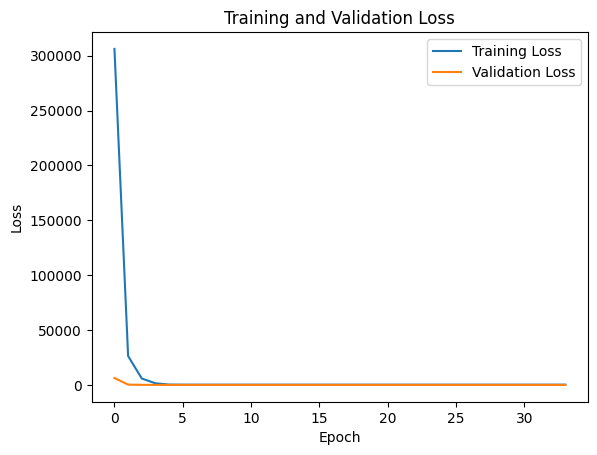

Model saved to models/gcn_2l_graph_random.pth
Average Time per Epoch: 0.50s
Average CPU Usage: 2.16GB
Average Memory Usage: 2.72GB

Total Training Time: 16.88s
Max CPU Usage: 4.20GB
Max Memory Usage: 2.78GB


In [25]:
set_seed(42)
gcn2_graph_random = GCN2Layer(num_features_random, 64, num_classes)
print(gcn2_graph_random)
print(f"Total number of trainable parameters: {(gcn1_graph_random.count_parameters())}\n")
train_graph(gcn2_graph_random, train_loader_random, val_loader_random, lr=0.01, 
            num_epochs=150, patience=10, save_path='models/gcn_2l_graph_random.pth')

In [26]:
test_graph(gcn2_graph_random, test_loader_random)

Confusion Matrix:
[[ 0  0 24]
 [ 0  0 24]
 [ 0  0 18]]
Accuracy: 0.2727
Average Sensitivity (Recall): 0.3333
Average Specificity: 0.6667


##### Degree features

GCN2Layer(
  (gcn1): GCN (1 -> 64)
  (gcn2): GCN (64 -> 128)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Total number of trainable parameters: 8835

Epoch 1, Train Loss: 1844823.0893554688, Val Loss: 34807.09680175781
Time: 0.55s, CPU: 3.37GB, Memory: 2.74GB
Epoch 2, Train Loss: 139537.11868286133, Val Loss: 15470.293029785156
Time: 0.48s, CPU: 2.01GB, Memory: 2.74GB
Epoch 3, Train Loss: 54823.680099487305, Val Loss: 4542.404754638672
Time: 0.48s, CPU: 1.98GB, Memory: 2.72GB
Epoch 4, Train Loss: 20482.270294189453, Val Loss: 2645.7163467407227
Time: 0.48s, CPU: 2.04GB, Memory: 2.69GB
Epoch 5, Train Loss: 26808.643112182617, Val Loss: 2611.098701477051
Time: 0.49s, CPU: 2.23GB, Memory: 2.72GB
Epoch 6, Train Loss: 15364.875732421875, Val Loss: 3027.1768341064453
Time: 0.48s, CPU: 2.30GB, Memory: 2.71GB
Epoch 7, Train Loss: 42541.075103759766, Val Loss: 669.642053604126
Time: 0.48s, CPU: 1.99GB, Memory: 2.71GB
Epoch 8, Train Loss: 16755.621910095215, Val Loss: 376.6234216

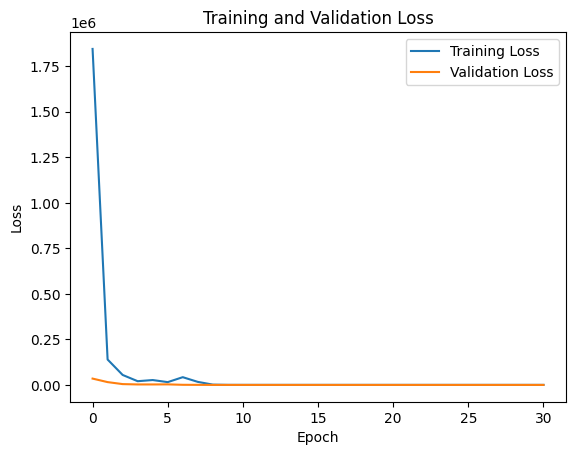

Model saved to models/gcn_2l_graph_degree.pth
Average Time per Epoch: 0.54s
Average CPU Usage: 2.51GB
Average Memory Usage: 2.68GB

Total Training Time: 16.81s
Max CPU Usage: 4.01GB
Max Memory Usage: 2.74GB


In [27]:
set_seed(42)
gcn2_graph_degree = GCN2Layer(num_features_degree, 64, num_classes)
print(gcn2_graph_degree)
print(f"Total number of trainable parameters: {gcn2_graph_degree.count_parameters()}\n")
train_graph(gcn2_graph_degree, train_loader_degree, val_loader_degree, lr=0.01, 
            num_epochs=150, patience=10, save_path='models/gcn_2l_graph_degree.pth')

In [28]:
test_graph(gcn2_graph_degree, test_loader_degree)

Confusion Matrix:
[[ 0  0 24]
 [ 0  0 24]
 [ 0  0 18]]
Accuracy: 0.2727
Average Sensitivity (Recall): 0.3333
Average Specificity: 0.6667


##### Laplacian Features

GCN2Layer(
  (gcn1): GCN (8 -> 64)
  (gcn2): GCN (64 -> 128)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Total number of trainable parameters: 9283

Epoch 1, Train Loss: 1777.76992893219, Val Loss: 46.28566324710846
Time: 0.54s, CPU: 2.97GB, Memory: 2.63GB
Epoch 2, Train Loss: 311.78781938552856, Val Loss: 29.58026361465454
Time: 0.48s, CPU: 2.15GB, Memory: 2.65GB
Epoch 3, Train Loss: 257.1396703720093, Val Loss: 29.611162662506104
Time: 0.48s, CPU: 2.02GB, Memory: 2.65GB
Epoch 4, Train Loss: 256.0859396457672, Val Loss: 29.67642080783844
Time: 0.48s, CPU: 2.13GB, Memory: 2.62GB
Epoch 5, Train Loss: 253.80035853385925, Val Loss: 29.675918698310852
Time: 0.48s, CPU: 2.21GB, Memory: 2.60GB
Epoch 6, Train Loss: 252.09600687026978, Val Loss: 29.703689217567444
Time: 0.48s, CPU: 2.18GB, Memory: 2.58GB
Epoch 7, Train Loss: 250.3451418876648, Val Loss: 29.65427005290985
Time: 0.48s, CPU: 2.13GB, Memory: 2.60GB
Epoch 8, Train Loss: 249.04447746276855, Val Loss: 29.568377137184

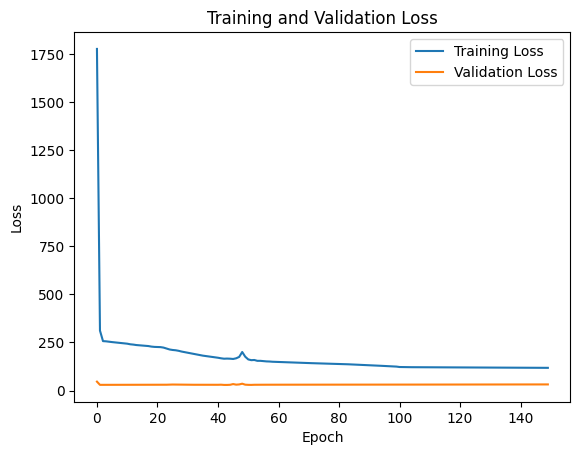

Model saved to models/gcn_2l_graph_laplacian.pth
Average Time per Epoch: 0.49s
Average CPU Usage: 2.14GB
Average Memory Usage: 2.65GB

Total Training Time: 74.23s
Max CPU Usage: 4.65GB
Max Memory Usage: 2.75GB


In [29]:
set_seed(42)
gcn2_graph_laplacian = GCN2Layer(num_features_laplacian, 64, num_classes)
print(gcn2_graph_laplacian)
print(f"Total number of trainable parameters: {gcn2_graph_laplacian.count_parameters()}\n")
train_graph(gcn2_graph_laplacian, train_loader_laplacian, val_loader_laplacian, lr=0.01, 
            num_epochs=150, patience=10, save_path='models/gcn_2l_graph_laplacian.pth')

In [30]:
test_graph(gcn2_graph_laplacian, test_loader_laplacian)

Confusion Matrix:
[[15  5  4]
 [ 7  4 13]
 [ 3  4 11]]
Accuracy: 0.4545
Average Sensitivity (Recall): 0.4676
Average Specificity: 0.7312


##### Cognitive Features

GCN2Layer(
  (gcn1): GCN (3 -> 64)
  (gcn2): GCN (64 -> 128)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Total number of trainable parameters: 8963

Epoch 1, Train Loss: 37071.733879089355, Val Loss: 912.5270576477051
Time: 0.74s, CPU: 5.30GB, Memory: 2.70GB
Epoch 2, Train Loss: 4269.815054893494, Val Loss: 142.8476243019104
Time: 0.59s, CPU: 4.09GB, Memory: 2.70GB
Epoch 3, Train Loss: 873.0682103633881, Val Loss: 55.842838525772095
Time: 0.55s, CPU: 3.47GB, Memory: 2.70GB
Epoch 4, Train Loss: 464.2985553741455, Val Loss: 66.55124473571777
Time: 0.53s, CPU: 3.33GB, Memory: 2.69GB
Epoch 5, Train Loss: 395.14765787124634, Val Loss: 44.148929715156555
Time: 0.53s, CPU: 3.56GB, Memory: 2.71GB
Epoch 6, Train Loss: 318.57594871520996, Val Loss: 31.577355980873108
Time: 0.52s, CPU: 3.46GB, Memory: 2.72GB
Epoch 7, Train Loss: 259.4249279499054, Val Loss: 29.85395836830139
Time: 0.90s, CPU: 5.22GB, Memory: 2.76GB
Epoch 8, Train Loss: 272.3252041339874, Val Loss: 31.553074479103

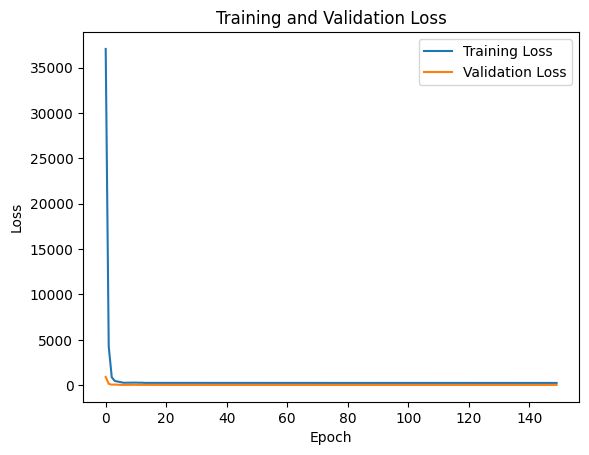

Model saved to models/gcn_2l_graph_cognitive.pth
Average Time per Epoch: 0.60s
Average CPU Usage: 2.92GB
Average Memory Usage: 2.79GB

Total Training Time: 90.62s
Max CPU Usage: 6.46GB
Max Memory Usage: 2.86GB


In [16]:
set_seed(42)
gcn2_graph_cognitive = GCN2Layer(num_features_cognitive, 64, num_classes)
print(gcn2_graph_cognitive)
print(f"Total number of trainable parameters: {gcn2_graph_cognitive.count_parameters()}\n")
train_graph(gcn2_graph_cognitive, train_loader_cognitive, val_loader_cognitive, lr=0.01, 
            num_epochs=150, patience=10, save_path='models/gcn_2l_graph_cognitive.pth')

In [17]:
test_graph(gcn2_graph_cognitive, test_loader_cognitive)

Confusion Matrix:
[[11  0 13]
 [ 2  2 20]
 [ 7  2  9]]
Accuracy: 0.3333
Average Sensitivity (Recall): 0.3472
Average Specificity: 0.6835


##### Cognitive (Word Feature)

GCN2Layer(
  (gcn1): GCN (1 -> 64)
  (gcn2): GCN (64 -> 128)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Total number of trainable parameters: 8835

Epoch 1, Train Loss: 63235.47772216797, Val Loss: 1480.0810775756836
Time: 1.03s, CPU: 1.49GB, Memory: 2.65GB
Epoch 2, Train Loss: 4825.045029163361, Val Loss: 54.45650768280029
Time: 0.60s, CPU: 3.59GB, Memory: 2.67GB
Epoch 3, Train Loss: 1674.0792026519775, Val Loss: 208.0406756401062
Time: 0.57s, CPU: 2.40GB, Memory: 2.68GB
Epoch 4, Train Loss: 1410.8528594970703, Val Loss: 150.72397184371948
Time: 0.52s, CPU: 2.22GB, Memory: 2.66GB
Epoch 5, Train Loss: 1025.3452587127686, Val Loss: 110.76654624938965
Time: 0.49s, CPU: 2.33GB, Memory: 2.65GB
Epoch 6, Train Loss: 1112.7769079208374, Val Loss: 55.2264347076416
Time: 0.51s, CPU: 2.63GB, Memory: 2.66GB
Epoch 7, Train Loss: 662.010281085968, Val Loss: 91.85513806343079
Time: 0.51s, CPU: 2.76GB, Memory: 2.66GB
Epoch 8, Train Loss: 992.9226622581482, Val Loss: 29.4931250810623

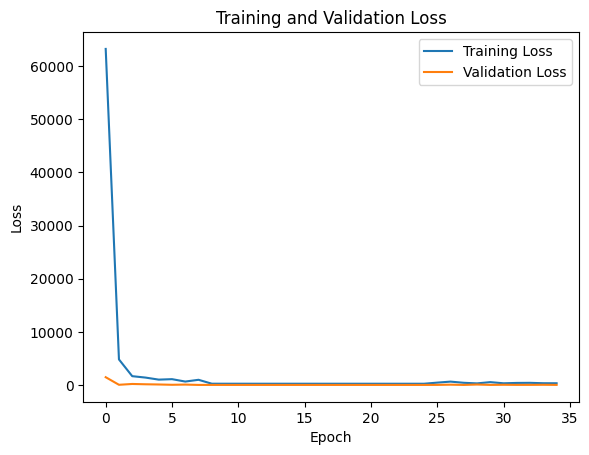

Model saved to models/gcn_2l_graph_cognitive_word.pth
Average Time per Epoch: 0.52s
Average CPU Usage: 2.29GB
Average Memory Usage: 2.68GB

Total Training Time: 18.22s
Max CPU Usage: 3.59GB
Max Memory Usage: 2.74GB


In [76]:
set_seed(42)
gcn2_graph_cognitive_word = GCN2Layer(num_features_cognitive_word, 64, num_classes)
print(gcn2_graph_cognitive_word)
print(f"Total number of trainable parameters: {gcn2_graph_cognitive_word.count_parameters()}\n")
train_graph(gcn2_graph_cognitive_word, train_loader_word, val_loader_word, lr=0.01, 
            num_epochs=150, patience=10, save_path='models/gcn_2l_graph_cognitive_word.pth')

In [77]:
test_graph(gcn2_graph_cognitive_word, test_loader_word)

Confusion Matrix:
[[ 5  0 19]
 [ 2  1 21]
 [ 2  1 15]]
Accuracy: 0.3182
Average Sensitivity (Recall): 0.3611
Average Specificity: 0.6825


## GCESN

### Variant 1

#### Single Run

##### Laplacian Features

GCESN_var1(
  (fc): Linear(in_features=8, out_features=3, bias=True)
)
Total number of trainable parameters: 27

Epoch 1, Train Loss: 259.4142014980316, Val Loss: 30.50285768508911
Time: 0.38s, CPU: 1.16GB, Memory: 2.86GB
Epoch 2, Train Loss: 257.1742467880249, Val Loss: 30.526048064231873
Time: 0.25s, CPU: 4.76GB, Memory: 2.84GB
Epoch 3, Train Loss: 257.08717346191406, Val Loss: 30.34934091567993
Time: 0.24s, CPU: 5.06GB, Memory: 2.85GB
Epoch 4, Train Loss: 256.42534375190735, Val Loss: 30.259730458259583
Time: 0.26s, CPU: 5.17GB, Memory: 2.83GB
Epoch 5, Train Loss: 255.76128244400024, Val Loss: 30.290632724761963
Time: 0.21s, CPU: 4.00GB, Memory: 2.85GB
Epoch 6, Train Loss: 255.21014404296875, Val Loss: 30.352025270462036
Time: 0.23s, CPU: 4.49GB, Memory: 2.83GB
Epoch 7, Train Loss: 254.78008556365967, Val Loss: 30.380903005599976
Time: 0.22s, CPU: 4.19GB, Memory: 2.80GB
Epoch 8, Train Loss: 254.39529871940613, Val Loss: 30.37335205078125
Time: 0.23s, CPU: 4.59GB, Memory: 2.81GB
Epoc

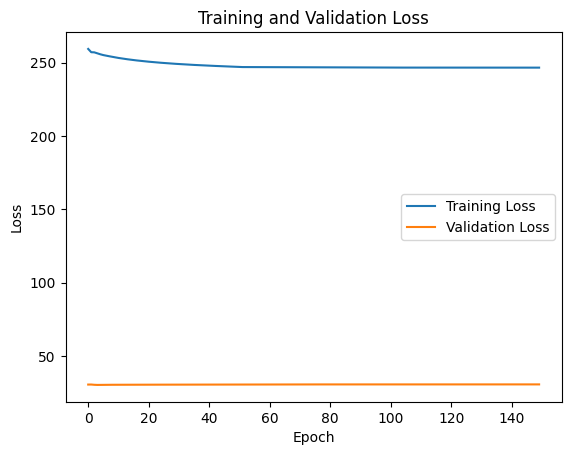

Model saved to models/gcesn_v1_graph_laplacian.pth
Average Time per Epoch: 0.33s
Average CPU Usage: 4.31GB
Average Memory Usage: 2.82GB

Total Training Time: 49.38s
Max CPU Usage: 6.45GB
Max Memory Usage: 2.94GB


In [72]:
# Create model instances
set_seed(42)
gcesn1_graph_laplacian = GCESN_var1(num_features_laplacian, num_features_laplacian, num_classes, num_iterations=1)
print(gcesn1_graph_laplacian)
print(f"Total number of trainable parameters: {gcesn1_graph_laplacian.count_parameters()}\n")
train_graph(gcesn1_graph_laplacian, train_loader_laplacian, val_loader_laplacian, lr=0.01, 
    num_epochs=150, save_path='models/gcesn_v1_graph_laplacian.pth')

In [73]:
test_graph(gcesn1_graph_laplacian, test_loader_laplacian)

Confusion Matrix:
[[ 8  4 12]
 [ 7  0 17]
 [ 4  2 12]]
Accuracy: 0.3030
Average Sensitivity (Recall): 0.3333
Average Specificity: 0.6637


##### Cognitive Feature

GCESN_var1(
  (fc): Linear(in_features=3, out_features=3, bias=True)
)
Total number of trainable parameters: 12

Epoch 1, Train Loss: 36254.4139251709, Val Loss: 2965.007125854492
Time: 0.39s, CPU: 3.12GB, Memory: 2.86GB
Epoch 2, Train Loss: 21585.544860839844, Val Loss: 1455.7753715515137
Time: 0.26s, CPU: 4.87GB, Memory: 2.82GB
Epoch 3, Train Loss: 11945.492557525635, Val Loss: 1241.4468040466309
Time: 0.23s, CPU: 4.43GB, Memory: 2.83GB
Epoch 4, Train Loss: 7427.873962402344, Val Loss: 332.43914794921875
Time: 0.26s, CPU: 5.07GB, Memory: 2.83GB
Epoch 5, Train Loss: 2570.0892753601074, Val Loss: 311.2893934249878
Time: 0.23s, CPU: 4.57GB, Memory: 2.80GB
Epoch 6, Train Loss: 2208.2798833847046, Val Loss: 114.28242015838623
Time: 0.25s, CPU: 4.92GB, Memory: 2.78GB
Epoch 7, Train Loss: 1397.3804483413696, Val Loss: 137.3909296989441
Time: 0.23s, CPU: 4.55GB, Memory: 2.77GB
Epoch 8, Train Loss: 1131.2097415924072, Val Loss: 95.76868915557861
Time: 0.24s, CPU: 4.81GB, Memory: 2.78GB
Epoch 

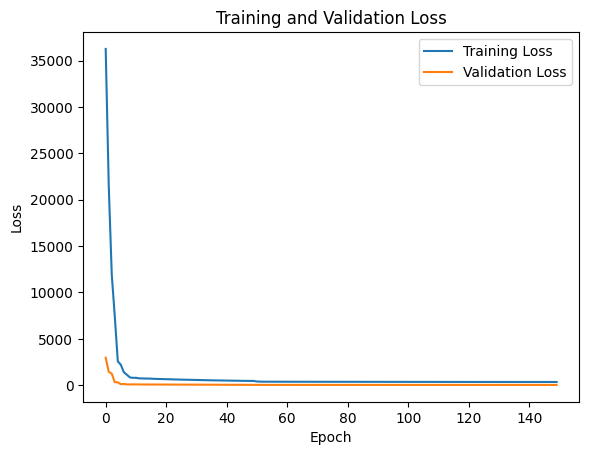

Model saved to models/gcesn_v1_graph_cognitive.pth
Average Time per Epoch: 0.33s
Average CPU Usage: 4.24GB
Average Memory Usage: 2.82GB

Total Training Time: 50.06s
Max CPU Usage: 6.14GB
Max Memory Usage: 2.92GB


In [74]:
set_seed(42)
gcesn1_graph_cognitive = GCESN_var1(num_features_cognitive, num_features_cognitive, num_classes, num_iterations=1)
print(gcesn1_graph_cognitive)
print(f"Total number of trainable parameters: {gcesn1_graph_cognitive.count_parameters()}\n")
train_graph(gcesn1_graph_cognitive, train_loader_cognitive, val_loader_cognitive, lr=0.01, num_epochs=150, 
            patience=10, save_path='models/gcesn_v1_graph_cognitive.pth')

In [75]:
test_graph(gcesn1_graph_cognitive, test_loader_cognitive)

Confusion Matrix:
[[10  3 11]
 [ 2 17  5]
 [ 6  7  5]]
Accuracy: 0.4848
Average Sensitivity (Recall): 0.4676
Average Specificity: 0.7460


#### Multiple Runs

In [93]:
gcesn1_graph = GCESN_var1(num_features_laplacian, num_features_laplacian, num_classes, num_iterations=1)
train_and_evaluate_multiple_runs_graph(gcesn1_graph, train_loader, val_loader, test_loader, path='models/multiple_run/gcesn_v1_graph_')

NameError: name 'train_loader' is not defined

### Variant 2

#### Single Run

##### Laplacian Features

GCESN_var2(
  (fc): Linear(in_features=8, out_features=3, bias=True)
)
Total number of trainable parameters: 27

Epoch 1, Train Loss: 259.4848380088806, Val Loss: 30.504933714866638
Time: 0.57s, CPU: 2.81GB, Memory: 2.78GB
Epoch 2, Train Loss: 257.25737714767456, Val Loss: 30.4995778799057
Time: 0.38s, CPU: 4.67GB, Memory: 2.77GB
Epoch 3, Train Loss: 257.1832466125488, Val Loss: 30.304678916931152
Time: 0.35s, CPU: 5.17GB, Memory: 2.77GB
Epoch 4, Train Loss: 256.49568033218384, Val Loss: 30.22295093536377
Time: 0.33s, CPU: 4.68GB, Memory: 2.77GB
Epoch 5, Train Loss: 255.82674384117126, Val Loss: 30.2637859582901
Time: 0.27s, CPU: 4.07GB, Memory: 2.77GB
Epoch 6, Train Loss: 255.27742910385132, Val Loss: 30.32470214366913
Time: 0.31s, CPU: 0.00GB, Memory: 2.77GB
Epoch 7, Train Loss: 254.85510683059692, Val Loss: 30.343952894210815
Time: 0.28s, CPU: 0.00GB, Memory: 2.77GB
Epoch 8, Train Loss: 254.4658977985382, Val Loss: 30.32713222503662
Time: 0.30s, CPU: 4.45GB, Memory: 2.78GB
Epoch 9, 

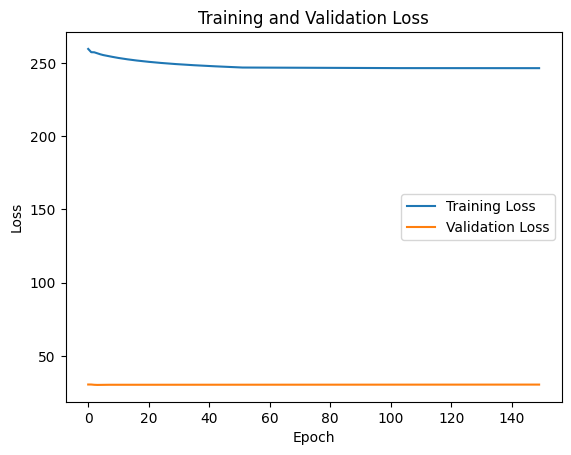

Model saved to models/gcesn_v2_graph_laplacian.pth
Average Time per Epoch: 0.40s
Average CPU Usage: 4.29GB
Average Memory Usage: 2.82GB

Total Training Time: 59.47s
Max CPU Usage: 6.98GB
Max Memory Usage: 2.94GB


In [76]:
set_seed(42)
gcesn2_graph_laplacian = GCESN_var2(num_features_laplacian, num_features_laplacian, num_classes, num_iterations=1)
print(gcesn2_graph_laplacian)
print(f"Total number of trainable parameters: {gcesn2_graph_laplacian.count_parameters()}\n")
train_graph(gcesn2_graph_laplacian, train_loader_laplacian, val_loader_laplacian, lr=0.01,
            num_epochs=150, save_path='models/gcesn_v2_graph_laplacian.pth')

In [77]:
test_graph(gcesn2_graph_laplacian, test_loader_laplacian)

Confusion Matrix:
[[ 8  4 12]
 [ 7  0 17]
 [ 4  2 12]]
Accuracy: 0.3030
Average Sensitivity (Recall): 0.3333
Average Specificity: 0.6637


##### Cognitive Features

GCESN_var2(
  (fc): Linear(in_features=3, out_features=3, bias=True)
)
Total number of trainable parameters: 12

Epoch 1, Train Loss: 36575.07997131348, Val Loss: 2989.819267272949
Time: 0.41s, CPU: 5.85GB, Memory: 2.79GB
Epoch 2, Train Loss: 21775.549476623535, Val Loss: 1467.5667572021484
Time: 0.25s, CPU: 3.98GB, Memory: 2.78GB
Epoch 3, Train Loss: 12049.445560455322, Val Loss: 1251.817554473877
Time: 0.27s, CPU: 4.18GB, Memory: 2.78GB
Epoch 4, Train Loss: 7493.766986846924, Val Loss: 335.04123401641846
Time: 0.26s, CPU: 4.21GB, Memory: 2.79GB
Epoch 5, Train Loss: 2592.047306060791, Val Loss: 313.9926481246948
Time: 0.26s, CPU: 3.82GB, Memory: 2.79GB
Epoch 6, Train Loss: 2227.5978803634644, Val Loss: 115.09299230575562
Time: 0.26s, CPU: 4.09GB, Memory: 2.79GB
Epoch 7, Train Loss: 1408.6765565872192, Val Loss: 138.3777937889099
Time: 0.28s, CPU: 0.00GB, Memory: 2.80GB
Epoch 8, Train Loss: 1140.0380582809448, Val Loss: 96.4924156665802
Time: 0.28s, CPU: 0.00GB, Memory: 2.80GB
Epoch 9,

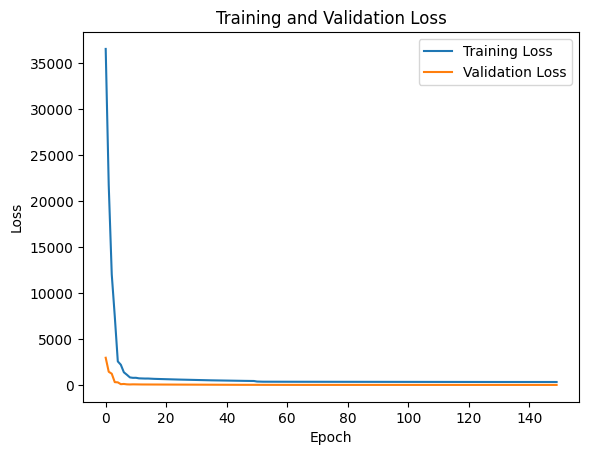

Model saved to models/gcesn_v2_graph_cognitive.pth
Average Time per Epoch: 0.30s
Average CPU Usage: 3.86GB
Average Memory Usage: 2.75GB

Total Training Time: 44.33s
Max CPU Usage: 6.16GB
Max Memory Usage: 2.84GB


In [78]:
set_seed(42)
gcesn2_graph_cognitive = GCESN_var2(num_features_cognitive, num_features_cognitive, num_classes, num_iterations=1)
print(gcesn2_graph_cognitive)
print(f"Total number of trainable parameters: {gcesn2_graph_cognitive.count_parameters()}\n")
train_graph(gcesn2_graph_cognitive, train_loader_cognitive, val_loader_cognitive, lr=0.01,
            num_epochs=150, save_path='models/gcesn_v2_graph_cognitive.pth')

In [79]:
test_graph(gcesn2_graph_cognitive, test_loader_cognitive)

Confusion Matrix:
[[10  3 11]
 [ 2 17  5]
 [ 6  7  5]]
Accuracy: 0.4848
Average Sensitivity (Recall): 0.4676
Average Specificity: 0.7460


#### Multiple Runs

In [45]:
gcesn2_graph = GCESN_var2(num_features, num_features, num_classes, num_iterations=1)
train_and_evaluate_multiple_runs_graph(gcesn2_graph, train_loader, val_loader, test_loader, path='models/multiple_run/gcesn_v2_graph_')


Run 1/50 -> Loss: 220.70804166793823
  Total Training Time: 121.48s, Avg CPU Usage: 17.47GB, Avg Memory Usage: 5.34GB, Max CPU Usage: 26.40GB, Max Memory Usage: 5.37GB
  Accuracy: 0.3485, Sensitivity: 0.3704, Specificity: 0.6776

Run 2/50 -> Loss: 220.5647543668747
  Total Training Time: 0.96s, Avg CPU Usage: 15.55GB, Avg Memory Usage: 5.33GB, Max CPU Usage: 17.32GB, Max Memory Usage: 5.33GB
  Accuracy: 0.3485, Sensitivity: 0.3704, Specificity: 0.6776

Run 3/50 -> Loss: 220.42047774791718
  Total Training Time: 2.91s, Avg CPU Usage: 19.81GB, Avg Memory Usage: 5.34GB, Max CPU Usage: 26.19GB, Max Memory Usage: 5.36GB
  Accuracy: 0.3485, Sensitivity: 0.3704, Specificity: 0.6776

Run 4/50 -> Loss: 220.28845024108887
  Total Training Time: 2.39s, Avg CPU Usage: 20.96GB, Avg Memory Usage: 5.34GB, Max CPU Usage: 24.96GB, Max Memory Usage: 5.35GB
  Accuracy: 0.3485, Sensitivity: 0.3704, Specificity: 0.6776

Run 5/50 -> Loss: 220.1646054983139
  Total Training Time: 1.02s, Avg CPU Usage: 15.69

## GCN-ESN

### Variant 1

#### Single Run

##### Laplacian Features

GCNESN_var1(
  (gcn1): GCN (8 -> 64)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Total number of trainable parameters: 771

Epoch 1, Train Loss: 262.0086269378662, Val Loss: 29.716596007347107
Time: 0.55s, CPU: 2.81GB, Memory: 2.88GB
Epoch 2, Train Loss: 253.6656951904297, Val Loss: 29.567698001861572
Time: 0.48s, CPU: 5.13GB, Memory: 2.88GB
Epoch 3, Train Loss: 246.1340229511261, Val Loss: 30.258565306663513
Time: 0.42s, CPU: 4.81GB, Memory: 2.88GB
Epoch 4, Train Loss: 241.16166770458221, Val Loss: 29.927156925201416
Time: 0.39s, CPU: 4.22GB, Memory: 2.84GB
Epoch 5, Train Loss: 237.05538833141327, Val Loss: 30.85431182384491
Time: 0.37s, CPU: 4.09GB, Memory: 2.81GB
Epoch 6, Train Loss: 232.55290496349335, Val Loss: 30.962297558784485
Time: 0.36s, CPU: 4.02GB, Memory: 2.80GB
Epoch 7, Train Loss: 228.80805349349976, Val Loss: 31.588437795639038
Time: 0.40s, CPU: 4.38GB, Memory: 2.76GB
Epoch 8, Train Loss: 224.5493814945221, Val Loss: 31.793057084083557
Time: 0.37s, CPU: 

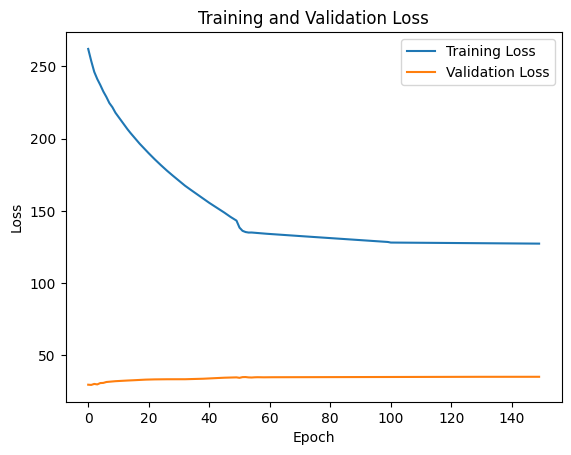

Model saved to models/gcnesn_v1_graph_laplacian.pth
Average Time per Epoch: 0.52s
Average CPU Usage: 4.04GB
Average Memory Usage: 2.76GB

Total Training Time: 77.28s
Max CPU Usage: 6.03GB
Max Memory Usage: 2.91GB


In [80]:
set_seed(42)
gcnesn1_graph_laplacian = GCNESN_var1(num_features_laplacian, 64, num_classes)
print(gcnesn1_graph_laplacian)
print(f"Total number of trainable parameters: {gcnesn1_graph_laplacian.count_parameters()}\n")
train_graph(gcnesn1_graph_laplacian, train_loader_laplacian, val_loader_laplacian, lr=0.01, 
    num_epochs=150, save_path='models/gcnesn_v1_graph_laplacian.pth')

In [81]:
test_graph(gcnesn1_graph_laplacian, test_loader_laplacian)

Confusion Matrix:
[[11  8  5]
 [ 6  5 13]
 [ 3  3 12]]
Accuracy: 0.4242
Average Sensitivity (Recall): 0.4444
Average Specificity: 0.7163


##### Cognitive Feature

GCNESN_var1(
  (gcn1): GCN (3 -> 64)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Total number of trainable parameters: 451

Epoch 1, Train Loss: 268.69042921066284, Val Loss: 30.765953421592712
Time: 0.51s, CPU: 2.39GB, Memory: 2.77GB
Epoch 2, Train Loss: 268.76033449172974, Val Loss: 30.019065499305725
Time: 0.39s, CPU: 4.66GB, Memory: 2.72GB
Epoch 3, Train Loss: 257.74560618400574, Val Loss: 30.09383475780487
Time: 0.38s, CPU: 4.40GB, Memory: 2.71GB
Epoch 4, Train Loss: 259.523206949234, Val Loss: 29.80831468105316
Time: 0.40s, CPU: 4.58GB, Memory: 2.72GB
Epoch 5, Train Loss: 257.66973304748535, Val Loss: 29.975626587867737
Time: 0.36s, CPU: 3.98GB, Memory: 2.70GB
Epoch 6, Train Loss: 260.0843894481659, Val Loss: 29.57675850391388
Time: 0.37s, CPU: 0.00GB, Memory: 2.73GB
Epoch 7, Train Loss: 257.0348927974701, Val Loss: 29.971287846565247
Time: 0.39s, CPU: 4.23GB, Memory: 2.72GB
Epoch 8, Train Loss: 257.6283941268921, Val Loss: 29.579816222190857
Time: 0.92s, CPU: 6.2

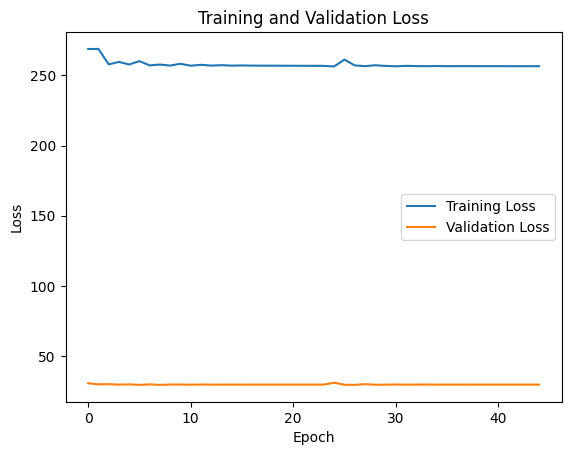

Model saved to models/gcnesn_v1_graph_cognitive.pth
Average Time per Epoch: 0.45s
Average CPU Usage: 3.94GB
Average Memory Usage: 2.73GB

Total Training Time: 20.33s
Max CPU Usage: 6.26GB
Max Memory Usage: 2.77GB


In [82]:
set_seed(42)
gcnesn1_graph_cognitive = GCNESN_var1(num_features_cognitive, 64, num_classes)
print(gcnesn1_graph_cognitive)
print(f"Total number of trainable parameters: {gcnesn1_graph_cognitive.count_parameters()}\n")
train_graph(gcnesn1_graph_cognitive, train_loader_cognitive, val_loader_cognitive, lr=0.01, 
    patience=20, num_epochs=150, save_path='models/gcnesn_v1_graph_cognitive.pth')

In [83]:
test_graph(gcnesn1_graph_cognitive, test_loader_cognitive)

Confusion Matrix:
[[ 0  0 24]
 [ 0  1 23]
 [ 0  0 18]]
Accuracy: 0.2879
Average Sensitivity (Recall): 0.3472
Average Specificity: 0.6736


##### Multiple Runs

In [ ]:
train_and_evaluate_multiple_runs_graph(gcnesn1_graph_laplacian, train_loader_laplacian, val_loader_laplacian, test_loader_laplacian)

In [ ]:
train_and_evaluate_multiple_runs_graph(gcnesn1_graph_cognitive, train_loader_cognitive, val_loader_cognitive, test_loader_cognitive)

### Variant 2

#### Single Run

##### Laplacian Features

GCNESN_var2(
  (gcn1): GCN (8 -> 64)
  (gcn2): GCN (64 -> 64)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Total number of trainable parameters: 4931

Epoch 1, Train Loss: 2990.252408027649, Val Loss: 50.44558596611023
Time: 0.79s, CPU: 3.30GB, Memory: 2.83GB
Epoch 2, Train Loss: 280.7627823352814, Val Loss: 29.845309853553772
Time: 0.84s, CPU: 5.05GB, Memory: 2.73GB
Epoch 3, Train Loss: 265.4857337474823, Val Loss: 30.968741297721863
Time: 1.28s, CPU: 4.82GB, Memory: 2.69GB
Epoch 4, Train Loss: 252.3587064743042, Val Loss: 30.8961124420166
Time: 1.77s, CPU: 5.64GB, Memory: 2.64GB
Epoch 5, Train Loss: 246.47062385082245, Val Loss: 29.965468525886536
Time: 0.98s, CPU: 4.46GB, Memory: 2.68GB
Epoch 6, Train Loss: 242.43177103996277, Val Loss: 30.32875120639801
Time: 1.82s, CPU: 5.54GB, Memory: 2.63GB
Epoch 7, Train Loss: 238.99915862083435, Val Loss: 30.178095817565918
Time: 0.90s, CPU: 4.41GB, Memory: 2.66GB
Epoch 8, Train Loss: 234.0551404953003, Val Loss: 30.532202124595

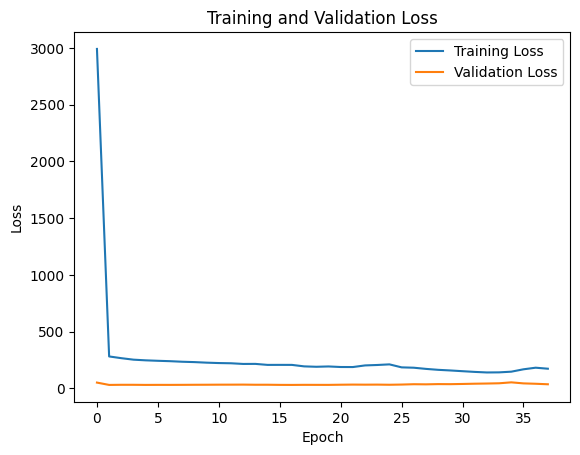

Model saved to models/gcnesn_v2_graph_laplacian.pth
Average Time per Epoch: 0.84s
Average CPU Usage: 4.08GB
Average Memory Usage: 2.70GB

Total Training Time: 31.85s
Max CPU Usage: 5.64GB
Max Memory Usage: 2.83GB


In [86]:
# Create model instances
set_seed(42)
gcnesn2_graph_laplacian = GCNESN_var2(num_features_laplacian, 64, num_classes)
print(gcnesn2_graph_laplacian)
print(f"Total number of trainable parameters: {gcnesn2_graph_laplacian.count_parameters()}\n")
train_graph(gcnesn2_graph_laplacian, train_loader_laplacian, val_loader_laplacian, lr=0.01, 
        num_epochs=150, save_path='models/gcnesn_v2_graph_laplacian.pth')

In [87]:
test_graph(gcnesn2_graph_laplacian, test_loader_laplacian)

Confusion Matrix:
[[ 7  5 12]
 [ 3  7 14]
 [ 2  3 13]]
Accuracy: 0.4091
Average Sensitivity (Recall): 0.4352
Average Specificity: 0.7163


##### Cognitive Features 

GCNESN_var2(
  (gcn1): GCN (3 -> 64)
  (gcn2): GCN (64 -> 64)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Total number of trainable parameters: 4611

Epoch 1, Train Loss: 8836.389680862427, Val Loss: 346.2932767868042
Time: 1.38s, CPU: 2.99GB, Memory: 2.65GB
Epoch 2, Train Loss: 2094.477300643921, Val Loss: 157.55308628082275
Time: 0.67s, CPU: 4.49GB, Memory: 2.68GB
Epoch 3, Train Loss: 1351.671630859375, Val Loss: 43.19588077068329
Time: 0.61s, CPU: 4.25GB, Memory: 2.67GB
Epoch 4, Train Loss: 1023.5302352905273, Val Loss: 98.29408121109009
Time: 0.60s, CPU: 4.28GB, Memory: 2.68GB
Epoch 5, Train Loss: 973.4408373832703, Val Loss: 63.215248346328735
Time: 0.75s, CPU: 3.95GB, Memory: 2.66GB
Epoch 6, Train Loss: 800.9976601600647, Val Loss: 113.34482717514038
Time: 0.76s, CPU: 4.04GB, Memory: 2.66GB
Epoch 7, Train Loss: 525.5306198596954, Val Loss: 47.18615806102753
Time: 0.69s, CPU: 3.70GB, Memory: 2.67GB
Epoch 8, Train Loss: 395.4165554046631, Val Loss: 31.42813611030578

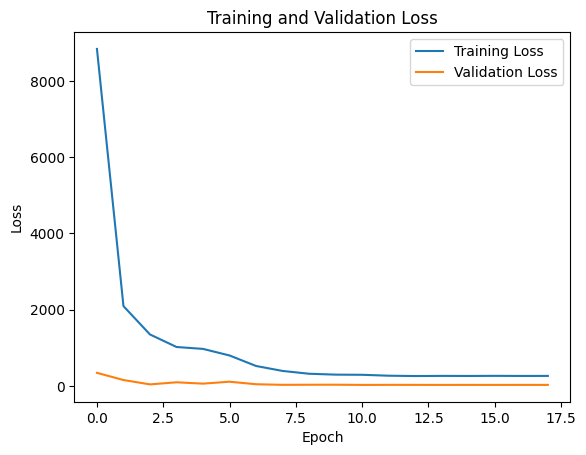

Model saved to models/gcnesn_v2_graph_cognitive.pth
Average Time per Epoch: 0.75s
Average CPU Usage: 3.87GB
Average Memory Usage: 2.67GB

Total Training Time: 13.45s
Max CPU Usage: 4.49GB
Max Memory Usage: 2.71GB


In [88]:
# Create model instances
set_seed(42)
gcnesn2_graph_cognitive = GCNESN_var2(num_features_cognitive, 64, num_classes)
print(gcnesn2_graph_cognitive)
print(f"Total number of trainable parameters: {gcnesn2_graph_cognitive.count_parameters()}\n")
train_graph(gcnesn2_graph_cognitive, train_loader_cognitive, val_loader_cognitive, lr=0.01, 
        num_epochs=150, save_path='models/gcnesn_v2_graph_cognitive.pth')

In [89]:
test_graph(gcnesn2_graph_cognitive, test_loader_cognitive)

Confusion Matrix:
[[ 0  0 24]
 [ 0  1 23]
 [ 0  1 17]]
Accuracy: 0.2727
Average Sensitivity (Recall): 0.3287
Average Specificity: 0.6657


#### Multiple Runs

In [95]:
train_and_evaluate_multiple_runs_graph(gcnesn2_graph_laplacian, train_loader_laplacian, val_loader_laplacian, test_loader_laplacian)


Run 1/50 -> Loss: 160.90426754951477
  Total Training Time: 11.91s, Avg CPU Usage: 3.97GB, Avg Memory Usage: 2.71GB, Max CPU Usage: 4.37GB, Max Memory Usage: 2.76GB
  Accuracy: 0.3788, Sensitivity: 0.4074, Specificity: 0.6925

Run 2/50 -> Loss: 128.4936881661415
  Total Training Time: 19.95s, Avg CPU Usage: 4.41GB, Avg Memory Usage: 2.80GB, Max CPU Usage: 5.86GB, Max Memory Usage: 2.85GB
  Accuracy: 0.4697, Sensitivity: 0.4954, Specificity: 0.7440

Run 3/50 -> Loss: 128.72747242450714
  Total Training Time: 14.33s, Avg CPU Usage: 4.41GB, Avg Memory Usage: 2.68GB, Max CPU Usage: 5.75GB, Max Memory Usage: 2.75GB
  Accuracy: 0.3939, Sensitivity: 0.4028, Specificity: 0.6944

Run 4/50 -> Loss: 192.44948709011078
  Total Training Time: 11.93s, Avg CPU Usage: 3.21GB, Avg Memory Usage: 2.68GB, Max CPU Usage: 4.54GB, Max Memory Usage: 2.70GB
  Accuracy: 0.3939, Sensitivity: 0.3843, Specificity: 0.6935

Run 5/50 -> Loss: 58.835814006626606
  Total Training Time: 12.85s, Avg CPU Usage: 2.78GB, A

In [96]:
train_and_evaluate_multiple_runs_graph(gcnesn2_graph_cognitive, train_loader_cognitive, val_loader_cognitive, test_loader_cognitive)


Run 1/50 -> Loss: 251.56603693962097
  Total Training Time: 101.32s, Avg CPU Usage: 2.22GB, Avg Memory Usage: 2.94GB, Max CPU Usage: 4.70GB, Max Memory Usage: 3.09GB
  Accuracy: 0.2727, Sensitivity: 0.3287, Specificity: 0.6657

Run 2/50 -> Loss: 251.50448751449585
  Total Training Time: 9.45s, Avg CPU Usage: 2.43GB, Avg Memory Usage: 2.98GB, Max CPU Usage: 2.74GB, Max Memory Usage: 3.01GB
  Accuracy: 0.2727, Sensitivity: 0.3287, Specificity: 0.6657

Run 3/50 -> Loss: 251.44230389595032
  Total Training Time: 10.05s, Avg CPU Usage: 2.44GB, Avg Memory Usage: 2.96GB, Max CPU Usage: 2.84GB, Max Memory Usage: 2.99GB
  Accuracy: 0.2727, Sensitivity: 0.3287, Specificity: 0.6657

Run 4/50 -> Loss: 251.39384770393372
  Total Training Time: 13.15s, Avg CPU Usage: 2.90GB, Avg Memory Usage: 2.87GB, Max CPU Usage: 5.06GB, Max Memory Usage: 2.97GB
  Accuracy: 0.2727, Sensitivity: 0.3287, Specificity: 0.6657

Run 5/50 -> Loss: 251.3566915988922
  Total Training Time: 13.71s, Avg CPU Usage: 3.14GB, A

# Inference Consumption

In [35]:
def measure_inference_performance(model, loader):
    model.to(device)
    model.eval()
    inference_times = []
    cpu_usages = []
    memory_usages = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)

            start_time = time.time()
            cpu_start = psutil.cpu_percent(interval=None)
            mem_start = psutil.virtual_memory().used

            output = model(x, adj_matrix, batch)

            cpu_end = psutil.cpu_percent(interval=None)
            mem_end = psutil.virtual_memory().used
            end_time = time.time()

            inference_times.append(end_time - start_time)
            cpu_usages.append((cpu_end - cpu_start) / 100 * psutil.virtual_memory().total / (1024**2))
            memory_usages.append((mem_end - mem_start) / (1024**2))

    avg_inference_time = np.mean(inference_times)
    avg_cpu_usage = np.mean(cpu_usages)
    avg_memory_usage = np.mean(memory_usages)

    print(f'Average Inference Time: {avg_inference_time:.6f}s')
    print(f'Average CPU Usage: {avg_cpu_usage:.6f}MB')
    print(f'Average Memory Usage: {avg_memory_usage:.6f}MB')

    return
    # return avg_inference_time, avg_cpu_usage, avg_memory_usage

In [37]:
print('\nInference 1-Layer GCN:')
measure_inference_performance(gcn1_graph, test_loader)

print('\nInference 2-Layer GCN:')
measure_inference_performance(gcn2_graph, test_loader)

print('\nInference GCESN Var-1:')
measure_inference_performance(gcesn1_graph, test_loader)

print('\nInference GCESN Var-2:')
measure_inference_performance(gcesn2_graph, test_loader)

print('\nInference GCNESN Var-1:')
measure_inference_performance(gcnesn1_graph, test_loader)

print('\nInference GCNESN Var-2:')
measure_inference_performance(gcnesn2_graph, test_loader)


Inference 1-Layer GCN:
Average Inference Time: 0.002362s
Average CPU Usage: -8419.075000MB
Average Memory Usage: 0.164062MB

Inference 2-Layer GCN:
Average Inference Time: 0.003037s
Average CPU Usage: -20175.711875MB
Average Memory Usage: 0.000000MB

Inference GCESN Var-1:
Average Inference Time: 0.004048s
Average CPU Usage: -992.248125MB
Average Memory Usage: 0.164062MB

Inference GCESN Var-2:
Average Inference Time: 0.004274s
Average CPU Usage: -19584.372083MB
Average Memory Usage: 0.000000MB

Inference GCNESN Var-1:
Average Inference Time: 0.004328s
Average CPU Usage: -6414.533333MB
Average Memory Usage: 0.164062MB

Inference GCNESN Var-2:
Average Inference Time: 0.004685s
Average CPU Usage: -10654.138958MB
Average Memory Usage: 0.492188MB
